# Trait ranking and biomarkers analysis

This notebook contains code for visualizing the associations between traits and age, and for running the three trait ranking methods:

1. Added value ($R^2$) of trait to model performance (RFC and ElNet)

2. Pearson correlation ($r$) of trait to physiological age

3. Two-tailed t-test on trait values corresponding to the top PAR quartile and bottom PAR quartile

For a summary of the results (relative trait ranks, mean ranks, and scores from each of the three methods), please refer to the supplementary data files.

In [17]:
import numpy as np
import matplotlib.pyplot as pl
from scipy.stats import pearsonr, spearmanr
import pandas as pd
import csv
import math
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from operator import itemgetter

In [2]:
'''
'dataconf' object and methods adapted from 'AgeRatesTurnkey.py'
'''

class dataconf :
    
    # TODO: Fix all these directories
    graph_dir = "graphs/"
    results_dir = "results/"
    DataSaveRoot = "data/"
    SASdistRoot = ""
    dataFile = ""
    SASroots = [
        SASdistRoot+"Baseline_V6/English/4.Data/SAS_Datasets/",
        SASdistRoot+"Follow-up1_V3/4.Data/SAS_Datasets/",
        SASdistRoot+"Follow-up2_V2/4.Data/SAS_Datasets/",
        SASdistRoot+"Follow-up3_V1/4.Data/SAS_Datasets/",
    ]
    SASfiles = {
        "Assays" : [
                SASroots[0]+"Assays/labo_raw.sas7bdat",
                SASroots[1]+"Assays/labf1raw.sas7bdat",
                SASroots[2]+"Assays/labf2raw.sas7bdat",
                SASroots[3]+"Assays/labf3raw.sas7bdat",
        ],
        "Diseases" : [
                SASroots[0]+"Diseases/adju_ana.sas7bdat",
                SASroots[1]+"Diseases/adjf1ana.sas7bdat",
                SASroots[2]+"Diseases/adjf2ana.sas7bdat",
                SASroots[3]+"Diseases/adjf3ana.sas7bdat",
        ],
        "Drugs" : [
                SASroots[0]+"Drugs/fmc_ana.sas7bdat",
                SASroots[1]+"Drugs/fmcf1ana.sas7bdat",
                SASroots[2]+"Drugs/fmcf2ana.sas7bdat",
                SASroots[3]+"Drugs/fmcf3ana.sas7bdat",
        ],
        "EKG_Doppler" : [
                SASroots[0]+"EKG_ENG_Doppler/mar_raw.sas7bdat",
                SASroots[1]+"EKG_ENG_Doppler/marf1raw.sas7bdat",
                SASroots[2]+"EKG_ENG_Doppler/marf2raw.sas7bdat",
                SASroots[3]+"EKG_ENG_Doppler/marf3raw.sas7bdat",
        ],
        "Interview" : [
                SASroots[0]+"Interview/int_rawe.sas7bdat",
                SASroots[1]+"Interview/inf1rawe.sas7bdat",
                SASroots[2]+"Interview/inf2rawe.sas7bdat",
                SASroots[3]+"Interview/inf3rawe.sas7bdat",
        ],
        "Med-Exam" : [
                SASroots[0]+"Medical_Exam/cli_rawe.sas7bdat",
                SASroots[1]+"Medical_Exam/clf1rawe.sas7bdat",
                SASroots[2]+"Medical_Exam/clf2rawe.sas7bdat",
                SASroots[3]+"Medical_Exam/clf3rawe.sas7bdat",
        ],
        "Nutrients-A" : [
                SASroots[0]+"Nutrients_Intake/alim_raw.sas7bdat",
                SASroots[1]+"Nutrients_Intake/alif1raw.sas7bdat",
                SASroots[2]+"Nutrients_Intake/alif2raw.sas7bdat",
                SASroots[3]+"Nutrients_Intake/alif3raw.sas7bdat",
        ],
        "Nutrients-B" : [
                SASroots[0]+"Nutrients_Intake/epic_raw.sas7bdat",
                SASroots[1]+"Nutrients_Intake/epif1raw.sas7bdat",
                SASroots[2]+"Nutrients_Intake/epif2raw.sas7bdat",
                SASroots[3]+"Nutrients_Intake/epif3raw.sas7bdat",
        ],
        "Nutrients-C" : [
                SASroots[0]+"Nutrients_Intake/nutr_raw.sas7bdat",
                SASroots[1]+"Nutrients_Intake/nutf1raw.sas7bdat",
                SASroots[2]+"Nutrients_Intake/nutf2raw.sas7bdat",
                SASroots[3]+"Nutrients_Intake/nutf3raw.sas7bdat",
        ],
        "Phys-Exam" : [
                SASroots[0]+"Physical_Exam/per_ana.sas7bdat",
                SASroots[1]+"Physical_Exam/pef1_ana.sas7bdat",
                SASroots[2]+"Physical_Exam/pef2_ana.sas7bdat",
                SASroots[3]+"Physical_Exam/pef3_ana.sas7bdat",
        ],
        # These appear to be the raw values used for computing the above
        # "Exam-B" : [
        #         SASroots[0]+"Physical_Exam/per_rawe.sas7bdat",
        #         SASroots[1]+"Physical_Exam/pef1rawe.sas7bdat",
        #         SASroots[2]+"Physical_Exam/pef2rawe.sas7bdat",
        #         SASroots[3]+"Physical_Exam/pef3rawe.sas7bdat",
        # ],
    }
    DS_types = list(SASfiles.keys())

    # TODO: Potentially drop? Have user manually clean their data, prep for direct usage in Pt04
    # These are dropped because they contain dates or ages
    drop_col_norm = [
        "CODE98",   # Unique subject ID code
        "DATA_NAS", # Date of birth/Data di nascita
        # The waves use letter codes to distinguish similar columns:
        # X: baseline, Y: Followup 1, Z: Followup 2, Q: Followup 3
        "DATEM",    # Date of Baseline instrumental exam
        "AGEM",     # Age at Baseline instrumental exam
        "DATE",     # Date of Baseline performance evaluation
        "AGE",      # Age at Baseline performance eval (years)
        "EPCDATE",  # Date of Baseline EPIC questionnaire
        "EPCAGE",   # Age at Baseline EPIC(years)/Et(anni)
        "VDATE",    # Date of Baseline medical examination
        "VAGE",     # Age at Baseline medical exam (years)
        "V1_V5",    # Month of Baseline medical examination
        "V1_V6",    # Day of Baseline medical examination
        "V1_V7",    # Year of Baseline medical examination
        "1_V7",     # Month of Baseline interview
        "1_V8",     # Day of Baseline interview
        "1_V9",     # Year of Baseline interview
        "1_V13",    # years you have been wearing glasses
        "1_V16",    # years you have been using hearing aid
        "IDATE",    # Date of Baseline Interview
        "IAGE",     # Age at the Baseline interview (years)
        "I1_V7",    # Month of Baseline interview
        "I1_V8",    # Day of Baseline interview
        "I1_V9",    # Year of Baseline interview
        "DATEL",    # Date of Baseline urine/fasting blood
        "AGEL",     # Age at Baseline fasting blood/urine(yrs)
        "CANYR",    # Year earliest cancer dx reported BL
        "IPR1YR",   # Clinical ex yr if hypertension measured
        "IPR2YR",   # Year hypertension dx reported BL
        "EPATYR",   # Year chron liver disease reported BL
        "GASTYR",   # Year gastrointest operations BL
        "ANGYR",    # Year angina dx reported Baseline
        "MIYR",     # Year myocardial infarction dx Baseline
        "CHFYR",    # Congestive heart failure year dx BL
        "STRKYR",   # Stroke or TIA year dx Baseline
        "PARKYR",   # Parkinson's disease year dx BL
        "PADIYR",   # Clinical yr if PAD measured/ROSE PAD
        "DIB1YR",   # FBG>140 or glycosuria,clin exam Baseline
        "DIB2YR",   # blood glucose>140 or diab dx year BL
        "DB1AYR",   # FBG>=126 or glycosuria,clin exam BL
        "DB2AYR",   # blood glucose>=126 or diab dx year BL
        "BPCOYR",   # Chronic bronchitis/emphysema dx yr BL
        "ASTHYR",   # Bronchial asthma dx yr Baseline
        "FFEMYR",   # Hip fracture yr dx Baseline
        "ERNDYR",   # Year herniated disc reported Baseline
        "GONAYR",   # Year knee arthritis reported FUP1
        "ANCAYR",   # Year hip arthritis reported Baseline
        "POSMYR",   # Poss osteoporosis(men),pQCT,year
        "POSFYR",   # Poss osteoporosis(women),pQCT,year
        "RL24YR",   # Impaired renal function (via 24-hour) yr
        "RENLYR",   # Impaired renal function (via C-G) year
        "FirstVisitDate", # SARDINIA
        "SecondVisitDate", # SARDINIA
        "ThirdVisitDate", # SARDINIA
        "FourthVisitDate", # SARDINIA
        "FifthVisitDate", # SARDINIA
        "pwvDate", # SARDINIA
        "Birthdate", # SARDINIA
        "Scandate", # SARDINIA
        "Subject#", # SARDINIA
        "date_neo", # SARDINIA
        "id_sir", # SARDINIA
        "id_mad", # SARDINIA
        "Wave", # SARDINIA
        "Visit", # SARDINIA
        "Occupation", # SARDINIA
        "Education", # SARDINIA
        "MaritalStatus" # SARDINIA
    ]

    common_col_norm = [
        "id_individual", # Needed to track samples
        "Age", # target variable
        "labsRBC",   #
        "labsHB", # 
        "labsMCV",    # 
        "labsMCH",     # 
        "labsWBC",     # 
        "labsPercNE",      # 
        "labsPercLY",  # 
        "labsPercMO",   # 
        "labsPercEO",    # 
        "labsPercBA",     #
        "V1_V5",
        "labsPLT",
        "labsHBF",
        "labsHBA2",
        "labsG6PD",
        "labsGlicemia",
        "labsInsulinemia",
        "labsAzotemia",
        "labsALT",
        "labsAST",
        "labsGammaGT",
        "labsFibrinogeno",
        "labsSideremia",
        "labsTransferrina",
        "labsBilirubinad",
        "labsBilirubinat",
        "labsAcidourico",
        "labsSodiemia",
        "labsPotassiemia",
        "labsVES",
        "labsPCR",
        "labsTSH",
        "labsFt4",
        "assayAdip",
        "assayLeptin",
        "assayMCP1",
        "assayIL6",
        "labsMCHC",
        "labsHtc",
        "labsMO_COUNT",
        "labsEO_COUNT",
        "labsBA_COUNT",
        "labsLY_COUNT",
        "labsNE_COUNT",
        "labsCreatinina",
        "labsColesterolo",
        "labsHDL",
        "labsTrigliceridi",
        "exmHeight",
        "exmWeight",
        "exmWaist",
        "exmHip",
        "exmBMI",
        "exmBPsys_jbs",
        "exmBPdia_jbs"
    ]

    common_cardio_col_norm = [
        "id_individual", # Needed to track samples
        "Age", # target variable
        "labsRBC",   #
        "labsHB", # 
        "labsMCV",    # 
        "labsMCH",     # 
        "labsWBC",     # 
        "labsPercNE",      # 
        "labsPercLY",  # 
        "labsPercMO",   # 
        "labsPercEO",    # 
        "labsPercBA",     #
        "V1_V5",
        "labsPLT",
        "labsHBF",
        "labsHBA2",
        "labsG6PD",
        "labsGlicemia",
        "labsInsulinemia",
        "labsAzotemia",
        "labsALT",
        "labsAST",
        "labsGammaGT",
        "labsFibrinogeno",
        "labsSideremia",
        "labsTransferrina",
        "labsBilirubinad",
        "labsBilirubinat",
        "labsAcidourico",
        "labsSodiemia",
        "labsPotassiemia",
        "labsVES",
        "labsPCR",
        "labsTSH",
        "labsFt4",
        "assayAdip",
        "assayLeptin",
        "assayMCP1",
        "assayIL6",
        "labsMCHC",
        "labsHtc",
        "labsMO_COUNT",
        "labsEO_COUNT",
        "labsBA_COUNT",
        "labsLY_COUNT",
        "labsNE_COUNT",
        "labsCreatinina",
        "labsColesterolo",
        "labsHDL",
        "labsTrigliceridi",
        "exmHeight",
        "exmWeight",
        "exmWaist",
        "exmHip",
        "exmBMI",
        "exmBPsys_jbs",
        "exmBPdia_jbs",
        "pwvQual",
        "pwv",
        "vasPSV",
        "vasEDV",
        "vasIP",
        "vasSDratio",
        "vasAT",
        "vasvti",
        "vasSysDiam",
        "vasDiaDiam",
        "vasIMT"
    ]

    # TODO: Have the user manually input their own bins for each wave?
    # These are emirically determined using the Pt-02-Binning.ipynb notebook
    # BestBins[wavenum][bin_yrs] = (age_start, age_end, n_train, n_test)
    BestBins = {
#         0 : {
#             7 : (24,87,36,2),
#             6 : (21,87,29,2),
#             # 6 : (22,88,30,2),
#             # 6 : (23,89,31,2),
#             # 6 : (24,90,25,2),
#             # 6 : (25,85,25,2),
#         },
#         1 : {
#             7 : (27,83,33,2),
#             6 : (26,86,25,2),
#         },
#         2 : {
#             7 : (32,88,31,2),
#             6 : (29,89,25,2),
#         },
#         3 : {
#             7 : (35,84,30,2),
#             6 : (31,85,25,2),
#         },
    }
    
    # These are empirically determined using the Pt-04-BestModels.ipynb notebook
    # N.B.: As LDA features are generally better than raw, values reported are for LDA features only
    BestNFeat = {
#         'KNNc-Fsr-b7s24t36-w0' : 55,
#         'KNNc-Fsr-b7s27t33-w1' : 38,
#         'KNNc-Fsr-b7s32t31-w2' : 47,
#         'KNNc-Fsr-b7s35t30-w3' : 28,

#         'KNNc-Fsr-b6s21t29-w0' : 54, # 0.9078
#         'KNNc-Fsr-b6s26t25-w1' : 32, # 0.8317
#         'KNNc-Fsr-b6s29t25-w2' : 42, # 0.8181
#         'KNNc-Fsr-b6s31t25-w3' : 34, # 0.7693

#         'KNNc-Fsr-b6s22t30-w0' : 64, # 0.9059
#         'KNNc-Fsr-b6s23t31-w0' : 53, # 0.9065
#         'KNNc-Fsr-b6s24t25-w0' : 52, # 0.8931
#         'KNNc-Fsr-b6s25t25-w0' : 51, # 0.8847

#         'KNNr-Fsr-b6s21t29-w0' : 68, # 0.9097
#         'KNNr-Fsr-b6s26t25-w1' : 38, # 0.8359
#         'KNNr-Fsr-b6s29t25-w2' : 42, # 0.8206
#         'KNNr-Fsr-b6s31t25-w3' : 33, # 0.7714

#         'KNNr-Fsr-b6s22t30-w0' : 65, # 0.9074
#         'KNNr-Fsr-b6s23t31-w0' : 75, # 0.9096
#         'KNNr-Fsr-b6s24t25-w0' : 66, # 0.8947
#         'KNNr-Fsr-b6s25t25-w0' : 58, # 0.8873

#         'WNDc-Fsr-b6s25t25-w0' : 54,
#         'WNDc-Fsr-b6s26t25-w1' : 38, # 0.8111
#         'WNDc-Fsr-b6s29t25-w2' : 42, # 0.7888
#         'WNDc-Fsr-b6s31t25-w3' : 50, # 0.7263
        
#         'RFr-Fsr-b6s21t29-w0'  : 46, # 0.9011
#         'RFr-Fsr-b6s26t25-w1'  : 35, # 0.8325
#         'RFr-Fsr-b6s29t25-w2'  : 42, # 0.8137
#         'RFr-Fsr-b6s31t25-w3'  : 33, # 0.7643

#         'RFr-FsrNL-b6s21t29-w0'  : 58, # 0.9153 No LDA
#         'RFr-FsrNL-b6s26t25-w1'  : 56, # 0.8731 No LDA
#         'RFr-FsrNL-b6s29t25-w2'  : 75, # 0.8652 No LDA
#         'RFr-FsrNL-b6s31t25-w3'  : 66, # 0.8246 No LDA

#         'RFr-Fsr-b6s25t25-w0'   : 45, # 0.8760
#         'RFr-FsrNL-b6s25t25-w0' : 63, # 0.8988 No LDA
        
#         'RFc-Fsr-b6s21t29-w0'  : 54, # 0.8919
#         'RFc-Fsr-b6s26t25-w1'  : 36, # 0.8300
#         'RFc-Fsr-b6s29t25-w2'  : 42, # 0.8069
#         'RFc-Fsr-b6s31t25-w3'  : 33, # 0.7559

#         'RFc-FsrNL-b6s21t29-w0'  : 51, # 0.9082 No LDA
#         'RFc-FsrNL-b6s26t25-w1'  : 62, # 0.8831 No LDA
#         'RFc-FsrNL-b6s29t25-w2'  : 58, # 0.8709 No LDA
#         'RFc-FsrNL-b6s31t25-w3'  : 55, # 0.8354 No LDA
    }

    # Dicts for keeping track of feature functions, classifiers and regressors defined below
    FeatFuncInfoByName = {}
    FeatFuncByName = {}
    FeatFuncLabelByName = {}

    ModelByModelName = {}
    ModelNameByModel = {}
    ModelTypeByModel = {}
    ModelLabelByModelName = {}
 
    def NormColNames (colname):
        colRE = "^([PVIFA]?)([XYZQ])(_?)(.+)$"
        colAGERE = "(^.+)?AGE(.+$)?"
        waveletters = ["X","Y","Z","Q"]
        normcol = colname
        m = re.search(colRE, colname)
        if m and m.groups()[1] in waveletters:
            normcol = m.groups()[3]
            if re.search (colAGERE, normcol):
                normcol = 'AGE'
                
        #     print ("{} -> {}".format(colname,normcol))
        # elif m:
        #     print ("{} -> {}".format(colname,m.groups()))
        # else:
        #     print ("{}: NO RE MATCH".format(colname))
        elif colname == 'CODE98':
            normcol = 'subj_id'
        return (normcol)
    
    def SAScols(sas7bdatObj):
        h = sas7bdatObj.header.parent
        cols = []
        enc = h.encoding
        enc_err = h.encoding_errors
        for col in h.columns:
            name = col.name.decode(enc,enc_err)
            desc = col.label.decode(enc,enc_err)
            norm = dataconf.NormColNames (name)
            if col.type == 'number' and col.format == 'DATE':
                fmt = 'date'
            else:
                fmt = col.type
            cols.append ({'name':name,'desc':desc,'norm':norm, 'fmt':fmt})
        return (cols)
    
    def BinLabel (bin_years,age_start,n_train):
        return ('b{}s{}t{}'.format (bin_years,age_start,n_train))

    def BestBinInfo (wavenum,bin_years):
        age_start, age_end, n_train, n_test, bin_lbl = (None,None,None,None,None)
#         if wavenum not in [0,1,2,3]:
#             raise ValueError('wavenum {} is invalid'.format(wavenum))
#         if bin_years not in [7,6]:
#             raise ValueError('bin_years {} is invalid'.format(bin_years))

        (age_start, age_end, n_train, n_test) = dataconf.BestBins[wavenum][bin_years]
        bin_lbl = dataconf.BinLabel (bin_years,age_start,n_train)        
        return (age_start, age_end, n_train, n_test, bin_lbl)

    def GetPredLabel (model_name,feat_func_name,nfeats,doLDA,bin_lbl,feature_type,nsplits):
        print("n splits: " + str(nsplits))
        model_label = dataconf.ModelLabelByModelName[model_name]
        feat_func_label = dataconf.FeatFuncLabelByName[feat_func_name]
        if not doLDA and not doLDA is None:
            feat_func_label += 'NL'

        if (nfeats):
            feat_label = feat_func_label+str(nfeats)
        else:
            feat_label = feat_func_label

        if bin_lbl is None:
            bin_lbl = ''
        else:
            bin_lbl = '-{}'.format(bin_lbl)

        if feature_type is None:
            feat_lbl = ''
        else:
            feat_lbl = '-{}'.format(feature_type)
        if nsplits is None:
            splits_label = ''
        elif nsplits >= 1000:
            splits_label = '-s'+str(int(nsplits/1000))+'k'
        else:
            splits_label = '-s'+str(nsplits)
        pred_label = '{}-{}{}{}{}'.format(model_label,feat_label,bin_lbl,feat_lbl,splits_label)
        return (pred_label)

  
    def GetBestNFeat (model_name,feat_func_name,bin_lbl,feature_type,numsplits):
        # Why no split #?
        best_feat_key = dataconf.GetPredLabel (model_name,feat_func_name,None,True,bin_lbl,feature_type,numsplits)
        best_feat_keyNL = dataconf.GetPredLabel (model_name,feat_func_name,None,False,bin_lbl,feature_type,numsplits)
        print(best_feat_key)
        if best_feat_keyNL in dataconf.BestNFeat:
            return (dataconf.BestNFeat[best_feat_keyNL], False)
        else:
            return (dataconf.BestNFeat[best_feat_key], True)

In [3]:
'''
Binning function retrieved from AgeRatesTurnkey.py
'''

def Get_Binned_Data (feature_type, filename, age_start=None, age_end=None):
    
    in_path = './RawData/' + filename
    
    if feature_type == 'sardinia_common':
        df = read_common_features(in_path)
    elif feature_type == 'sardinia_common_cardio':
        df = read_common_cardio_features(in_path)
    else:
        df = read_data_updated2 (in_path,'features')
    data_matrix, col_names, age_col_idx, id_col_idx = convert_data (df)
    age_col = data_matrix[:,age_col_idx]
    n_features = len (col_names) - 2
    print ('cleaned features: ' + str(n_features))
    print ('cleaned samples: ' + str(data_matrix.shape[0]))

    if age_start is None or age_end is None:
        if feature_type == 'inchianti':
            print ("using inchianti binning...")
            (age_start, age_end, n_train, n_test, bin_years) = (23, 89, 19, 2, 6)
        else:
            (age_start, age_end, n_train, n_test, bin_years) = (12, 77, 120, 13, 5)

    data_class_views, class_vals = bin_data (age_start, age_end, bin_years, data_matrix, age_col)
    return (data_matrix, age_col_idx, id_col_idx, data_class_views, class_vals, col_names)

In [4]:
'''
Data reading functions retrieved from AgeRatesTurnkey.py
'''

######################################################
def read_common_features(file_name):
    print ("Reading common clinical features...")
    x = pd.read_csv(file_name,sep='\t', na_values=[])
    x = x.dropna(axis=1, how='all')
    x = x.dropna(how='all')

    for feature_name in x.columns:
        if feature_name not in dataconf.common_col_norm:
            x = x.drop(feature_name, axis=1)

    threshold_num = 0.05
    for i in range (47):
        x = x.dropna(thresh=(x.shape[1]*threshold_num))
        x = x.dropna(axis=1, thresh=(x.shape[0]*threshold_num))
        threshold_num += 0.02
    x = x.dropna(how='any')

    return (x)

def read_common_cardio_features(file_name):
    print ("Reading common clinical features...")
    x = pd.read_csv(file_name,sep='\t', na_values=[])
    x = x.dropna(axis=1, how='all')
    x = x.dropna(how='all')

    for feature_name in x.columns:
        if feature_name not in dataconf.common_cardio_col_norm:
            x = x.drop(feature_name, axis=1)

    threshold_num = 0.05
    for i in range (47):
        x = x.dropna(thresh=(x.shape[1]*threshold_num))
        x = x.dropna(axis=1, thresh=(x.shape[0]*threshold_num))
        threshold_num += 0.02
    x = x.dropna(how='any')

    return (x)

def read_data_updated2(file_name, what_to_prioritize):
    x = pd.read_csv(file_name,sep='\t', na_values=[])
    x = x.dropna(axis=1, how='all')
    x = x.dropna(how='all')
    print ('initial feats:' + str(len(x.columns)))
    print ('initial samps:' + str(x.shape[0]))
    threshold_num = 0.05
    if what_to_prioritize is 'features':
        for i in range (47):
            x = x.dropna(thresh=(x.shape[1]*threshold_num))
            x = x.dropna(axis=1, thresh=(x.shape[0]*threshold_num))
            threshold_num += 0.02
        x = x.dropna(how='any')
    elif what_to_prioritize is 'samples':
        for i in range (47):
            x = x.dropna(axis=1, thresh=(x.shape[0]*threshold_num))
            x = x.dropna(thresh=(x.shape[1]*threshold_num))
            threshold_num += 0.02
        x = x.dropna(axis=1, how='any')
    else:
        return("Need to specify what to prioritize: 'features' or 'samples'")
    #x.to_csv("trimmedFile", sep='\t')

    x = clean_data(x)

    return (x)


def clean_data(x):    
    for drop_feature in dataconf.drop_col_norm:
        if drop_feature in x.columns:
            x = x.drop(drop_feature, axis=1)
    return (x)

def convert_data(df):
    data = df.as_matrix()
    col_names = df.columns.values
    return (data, col_names, df.columns.get_loc("Age"), df.columns.get_loc("id_individual"))


# In[13]:

def bin_data(start, end, size, data_matrix, age_col):
    bins = range (start, end+size, size)
    digitized = np.digitize(age_col, bins)

    views=[]
    for i in range (1,len(bins)):
        views.append (data_matrix[digitized == i,:])
#    views.pop()
    # initialize the class_values array (center of each bin)
    class_vals = [x+(size/2.0) for x in range(start, end, size)]
#    class_vals.pop()
    return (views, class_vals)
##############################################################3

def train_test_random (data_matrix, test_prop):
    from sklearn.model_selection import train_test_split
    train, test = train_test_split(data_matrix, test_size=test_prop)
    return (train, test)

def elastic_net(train_data, train_labels, test_data, test_labels):
    from sklearn.linear_model import ElasticNet
    regr = ElasticNet(tol=0.1)
    regr.fit(train_data, train_labels)
    predicted = regr.predict(test_data)
    return (predicted)

def rand_forest(train_data, train_labels, test_data, test_labels):
    from sklearn.ensemble import RandomForestRegressor
    forest = RandomForestRegressor(n_estimators=30)
    forest.fit(train_data, train_labels)
    predicted = forest.predict(test_data)
    return (predicted)

def rand_forest_clf(train_classed_data, int_classed_labels, test_classed_data, train_classed_labels):
    from sklearn.ensemble import RandomForestClassifier
    clf = RandomForestClassifier(n_estimators = 30)
    predicted_classes, predicted_values = generic_classifier (clf, train_classed_data, int_classed_labels, test_classed_data, train_classed_labels)
    return (predicted_values)

def score (x, y):
    from scipy import stats
    rscore, p = stats.pearsonr(x, y)
    r2score = rscore**2
    return (r2score)

def average_list (lst):
    new_lst = []
    i = 0
    while i < len(lst[0]):
        sum_samples = 0
        for sample in lst:
            sum_samples += sample[i]
        avg = sum_samples / len(lst)
        new_lst.append(avg)
        i += 1
    return (new_lst)

##########################################

In [5]:
def lda(train, test, train_classed_labels):
    lda = LinearDiscriminantAnalysis()
    lda_train = lda.fit(train, train_classed_labels).transform(train)
    lda_test = lda.transform(test)
    return (lda_train, lda_test)

def marg_probs_to_pred_values (marg_probs_list, class_vals):
    weighted = marg_probs_list*np.array(class_vals)
    return (np.sum(weighted, axis=1))

def generic_classifier (clf, train_classed_data, int_classed_labels, test_classed_data, train_classed_labels):
    clf.fit(train_classed_data, int_classed_labels)
    predicted_class_labels = clf.predict(test_classed_data)
    predicted_classes = [float(s) for s in predicted_class_labels]
    #class_values = [float(s) for s in clf.classes_]
    predicted_values = marg_probs_to_pred_values (clf.predict_proba(test_classed_data), train_classed_labels)
    return (predicted_classes, predicted_values)

### Take-One-Out

In [6]:
def takeOneOutFeatureAnalysis_elnet (data_matrix, feature_names, age_col_idx, id_col_idx, num_iters, filename, N, title, baseline=0.85):
    '''
    Calculates the added value (R^2) for each trait in specified 'data_matrix' (cols corresponding to traits) using the
    Elastic Net model.
    Input parameters are the outputs of the Get_Binned_Data function
    'baseline' = specified baseline R^2 score (corresponds to full model) such that: added value = baseline - R^2
    '''
    scores_list = []
    N = N - 1
    
    feature_names = np.delete(feature_names, age_col_idx)
    feature_names = np.delete(feature_names, id_col_idx)
    
    n = 0
    while n < num_iters:
            
        train, test = train_test_random(data_matrix, 0.1)
    
        scores = []

        train_ages = train[:,age_col_idx]
        test_ages = test[:,age_col_idx]

        train = np.delete(train, age_col_idx, axis=1)
        train = np.delete(train, id_col_idx, axis=1)
        test = np.delete(test, age_col_idx, axis=1)
        test = np.delete(test, id_col_idx, axis=1)
        
        for i, feat in enumerate(feature_names):
            new_train = np.delete(train, i, axis=1) # cut out feat col
            new_test = np.delete(test, i, axis=1)
            predicted_ages = elastic_net(new_train, train_ages, new_test, test_ages)
            r2score = score(predicted_ages, test_ages)
            scores.append(r2score)
        
        scores_list.append(scores)
        
        n += 1
    
    scores_list = average_list(scores_list)
    sorted_idxs = np.argsort (np.array(scores_list))
    rank_order_feats = feature_names[sorted_idxs]
    rank_order_scores = np.array(scores_list)[sorted_idxs]
    
    file_list = [rank_order_feats, rank_order_scores]
    
    with open('./Results/top_features/'+filename+".csv", "w") as f:
        writer = csv.writer(f)
        writer.writerows(file_list)
    
    rank_order_scores = [baseline-x for x in rank_order_scores]
    
    pl.figure(figsize=(8,3))
    pl.title(title)
    #pl.xlabel('Top '+str(N) +' rank-ordered features')
    pl.ylabel('Added value, $R^2$', fontsize=14)
    #pl.bar(range(len(rank_order_feats[:N])), rank_order_scores[:N], color=[0.5,0,0], align='center')
    pl.bar(range(len(rank_order_feats[:N])), rank_order_scores[:N], color='#86AC41', align='center')
    pl.xticks(range(len(rank_order_feats[:N])), rank_order_feats[:N], size='small', rotation=90)
    pl.xlim(min(range(len(rank_order_feats[:N])))-0.5,max(range(len(rank_order_feats[:N])))+0.5)
    pl.tick_params(axis='both', which='major', labelsize=12)
    pl.tick_params(axis='both', which='minor', labelsize=12)
    pl.tight_layout()
    pl.savefig('./Figures/TopFeats/'+filename+'_missingfeatures.png', dpi=800)
    pl.show()
    
    return (rank_order_feats, rank_order_scores)

In [7]:
def takeOneOutFeatureAnalysis_rfc (data_matrix, data_class_views, class_vals, feature_names, age_col_idx, id_col_idx, num_iters, filename, N, title, baseline=0.85):
    '''
    Calculates the added value (R^2) for each trait in specified 'data_matrix' (cols corresponding to traits) using the
    Random Forest Classifier model.
    Input parameters are the outputs of the Get_Binned_Data function
    'baseline' = specified baseline R^2 score (corresponds to full model) such that: added value = baseline - R^2
    '''
    scores_list = []
    N = N - 1
    
    feature_names = np.delete(feature_names, age_col_idx)
    feature_names = np.delete(feature_names, id_col_idx)
    
    n = 0
    while n < num_iters:
        
        # get classed labels
        classed_train = np.vstack(data_class_views)
        classes = []
        int_classes = []
        for j, view in enumerate(data_class_views):
            classes.append(np.ones(view.shape[0])*class_vals[j])
            int_classes.append(np.ones(view.shape[0])*j)
        classed_labels = np.concatenate(classes)
        classed_labels = classed_labels.reshape((len(classed_labels),1))
        int_classed_labels = np.concatenate(int_classes)
        int_classed_labels = int_classed_labels.reshape((len(int_classed_labels),1))
        
        data_matrix = np.vstack(data_class_views)
        data_matrix = np.hstack([data_matrix,classed_labels,int_classed_labels])
        
        train, test = train_test_random(data_matrix, 0.1)
    
        scores = []

        train_ages = train[:,age_col_idx]
        test_ages = test[:,age_col_idx]
        
        train_classed_labels = train[:,-2]
        int_classed_labels = train[:,-1]

        train = np.delete(train, age_col_idx, axis=1)
        train = np.delete(train, id_col_idx, axis=1)
        test = np.delete(test, age_col_idx, axis=1)
        test = np.delete(test, id_col_idx, axis=1)
        
        train = np.delete(train, -1, axis=1)
        test = np.delete(test, -1, axis=1)
        train = np.delete(train, -1, axis=1)
        test = np.delete(test, -1, axis=1)
        
        for i, feat in enumerate(feature_names):
            new_train = np.delete(train, i, axis=1) # cut out feat col
            new_test = np.delete(test, i, axis=1)
            lda_train, lda_test = lda(new_train, new_test, int_classed_labels)
            predicted_ages = rand_forest_clf(lda_train, int_classed_labels, lda_test, class_vals)
            r2score = score(predicted_ages, test_ages)
            scores.append(r2score)
        
        scores_list.append(scores)
        
        n += 1
    
    scores_list = average_list(scores_list)
    sorted_idxs = np.argsort (np.array(scores_list))
    rank_order_feats = feature_names[sorted_idxs]
    rank_order_scores = np.array(scores_list)[sorted_idxs]
    
    file_list = [rank_order_feats, rank_order_scores]
    
    with open('./Results/top_features/'+filename+".csv", "w") as f:
        writer = csv.writer(f)
        writer.writerows(file_list)
    
    rank_order_scores = [baseline-x for x in rank_order_scores]
    
    pl.figure(figsize=(8,3))
    pl.title(title,fontsize=14)
    #pl.xlabel('Top '+str(N) +' rank-ordered features', fontsize=14)
    pl.ylabel('Added value, $R^2$', fontsize=14)
    pl.bar(range(len(rank_order_feats[:N])), rank_order_scores[:N], color='#86AC41', align='center')
    pl.xticks(range(len(rank_order_feats[:N])), rank_order_feats[:N], size='small', rotation=90)
    pl.xlim(min(range(len(rank_order_feats[:N])))-0.5,max(range(len(rank_order_feats[:N])))+0.5)
    pl.tick_params(axis='both', which='major', labelsize=12)
    pl.tick_params(axis='both', which='minor', labelsize=12)
    pl.tight_layout()
    pl.savefig('./Figures/TopFeats/'+filename+'_missingfeatures.png', dpi=800)
    pl.show()
    
    return (rank_order_feats, rank_order_scores)

In [8]:
def takeOneFromFile (filename):
    path = './Results/top_features/'+filename+'.csv'
    import csv
    data_list = []
    with open(path) as csvDataFile:
        csvReader = csv.reader(csvDataFile)
        for line in csvReader:
            data_list.append(line)
    rank_order_feats = data_list[0]
    rank_order_scores = data_list[2]# skip empty line
    rank_order_scores = [float(score) for score in rank_order_scores]
    return (rank_order_feats, rank_order_scores)

### Pearson scoring

In [41]:
def PearsonFeatures (data_file, filename, title, data_matrix, age_col_idx, id_col_idx, feature_names, N, bound='none',
                    log_p_thresh=15, r_thresh=0.8, spearman=False, plot=True):
    '''
    Calculates correlation of trait values to the physiological age
    Visualizes the rank-ordered traits by correlation
    
    spearman = True / False --> use Spearman rank correlation instead of Pearson correlation
    '''
    # Read and process physiological age data
    try:
        data_x = np.genfromtxt('./Results/'+data_file+'.tsv', delimiter='\t')
    except:
        data_x = np.genfromtxt('./Results/'+data_file+'.csv', delimiter=',')

    x_ids = data_x[:,0]
    order_x = np.argsort(x_ids)

    # actual ages
    act_x = data_x[:,1]
    
    # predicted ages
    pred_x = data_x[:,2]
    
    # Rescale
    #fit_x = np.polyfit(act_x,pred_x,1)
    #fit_fn_x = np.poly1d(fit_x)
    #slope_x, intercept_x = np.polyfit(act_x, fit_fn_x(act_x),1)
    #pred_x = linearRescale(pred_x, slope_x, intercept_x)
    
    # rates
    x_act = []
    x_pred = []

    # Find identities in both sets and order them correspondingly
    for xidx, identity in enumerate(x_ids):
        if np.isnan(pred_x[xidx]) or np.isnan(act_x[xidx]):
            continue
        else:
            x_pred.append(float(pred_x[xidx]))
            x_act.append(float(act_x[xidx]))

    x_act = np.array(x_act)
    x_pred = np.array(x_pred)
            
    # BOUND
    if bound != 'none':
        lower_bound = bound[0]
        upper_bound = bound[1]
        # actual ages should be the same now
        middle_idxs = np.where((x_act >= lower_bound) & (x_act <= upper_bound))
        x_pred = x_pred[middle_idxs]
        x_ids = x_ids[middle_idxs]
    
    # Process SardiNIA features
    feature_names = np.delete(feature_names, age_col_idx)
    feature_names = np.delete(feature_names, id_col_idx)
    id_col = data_matrix[:,id_col_idx]
    data_matrix = np.delete(data_matrix, age_col_idx, 1)
    data_matrix = np.delete(data_matrix, id_col_idx, 1)
    
    label = []
    indices = []
    
    for i, ind in enumerate(id_col):
        if ind in x_ids:
            ind_idx, = np.where(x_ids==ind)
            label.append(x_pred[ind_idx])
            indices.append(i)
    
    feat_scores = []
    pvals = []
    
    for i, feat in enumerate(feature_names):
        if spearman is True:
            feat_score, p = spearmanr(np.array(label)[:,0], data_matrix[indices,i])
        else:
            feat_score, p = pearsonr(np.array(label)[:,0], data_matrix[indices,i])
        feat_scores.append(feat_score)
        pvals.append(p)
    
    identifier = 0.0 #np.nanmin(feat_scores)-1
    feat_scores = [identifier if math.isnan(x) else x for x in feat_scores] # replace NaNs with max+1 unique identifier
    #pvals = [1e6 if math.isnan(x) else x for x in pvals]
    pvals = [1e6 if math.isnan(feat_scores[i]) else pvals[i] for i in range(len(feat_scores))]
    pvals = [p+1e-300 for p in pvals]
    #ordered_feats = [feature_name for _,feature_name in sorted(zip(feat_scores,feature_names))]
    ordered_feats = [list(x) for x in zip(*sorted(zip(np.abs(feat_scores), feature_names), key=itemgetter(0)))][1]
    ordered_scores = [list(x) for x in zip(*sorted(zip(np.abs(feat_scores), feat_scores), key=itemgetter(0)))][1]
    ordered_pvals = [list(x) for x in zip(*sorted(zip(np.abs(feat_scores), pvals), key=itemgetter(0)))][1]
    #ordered_scores = [float('nan') if x==identifier else x for x in ordered_scores] # sub nan back in 
    
    # order from highest to lower
    ordered_feats = list(reversed(ordered_feats))
    ordered_scores = list(reversed(ordered_scores))
    ordered_pvals = list(reversed(ordered_pvals))
    log10_ordered_pvals = -np.log10(ordered_pvals)
    
    if plot is True:
        # Make bar plot
        #pl.figure(figsize=(8,3.5))
        pl.figure(figsize=(5,5))
        #pl.title(title, fontsize=14)
        if spearman is True:
            pl.xlabel(r'Spearman correlation, $\rho$', fontsize=14)
        else:
            pl.xlabel('Pearson correlation, $r$', fontsize=14)
        barplot = pl.barh(range(len(ordered_feats[:N])), ordered_scores[:N][::-1], color='#86AC41', align='center')
        for i in range(len(barplot)):
            if ordered_scores[:N][::-1][i] > 0:
                barplot[i].set_color('#86AC41')
            else:
                barplot[i].set_color('#7DA3A1')
        pl.yticks(range(len(ordered_feats[:N])), ordered_feats[:N][::-1], size='small')
        pl.ylim(min(range(len(ordered_feats[:N])))-0.5,max(range(len(ordered_feats[:N])))+0.5)
        pl.xlim(-1,1)
        pl.tick_params(axis='both', which='major', labelsize=12)
        pl.tick_params(axis='both', which='minor', labelsize=12)
        pl.tight_layout()
        if spearman is True:
            pl.savefig('./Figures/TopFeats/'+filename+'_spearman.png', dpi=800)
        else:
            pl.savefig('./Figures/TopFeats/'+filename+'_pearson.png', dpi=800)
        pl.show()

        # Make volcano plot
        pl.figure(figsize=(4,5))
        pl.ylabel('-log$_{10}$ (1E-300 + p-value)', fontsize=14)
        if spearman is True:
            pl.xlabel(r'Spearman correlation, $\rho$', fontsize=14)
        else:
            pl.xlabel('Pearson correlation, $r$', fontsize=14)
        pl.scatter(ordered_scores, log10_ordered_pvals, color='#86AC41', alpha=0.5, s=30)
        pl.xlim(-1,1)
        pl.ylim(-0.1,None)
        x_range = np.linspace(-1,1,10)
        pl.plot(x_range, -np.log10(1e-300+5*10**(-4)) * np.ones(len(x_range)), color='#324851', linestyle='--', linewidth=1.5)
        for i, txt in enumerate(ordered_feats):
            if log10_ordered_pvals[i] > log_p_thresh:
                pl.annotate(txt, (ordered_scores[i],log10_ordered_pvals[i]))
            elif np.abs(ordered_scores[i]) > r_thresh:
                if txt=='rxCatAntihipertensive':
                    pl.annotate(txt, (ordered_scores[i]-0.2,log10_ordered_pvals[i]-4))
                else:
                    pl.annotate(txt, (ordered_scores[i],log10_ordered_pvals[i]))
        pl.tick_params(axis='both', which='major', labelsize=12)
        pl.tick_params(axis='both', which='minor', labelsize=12)
        pl.tight_layout()
        if spearman is True:
            pl.savefig('./Figures/TopFeats/'+filename+'_spearman_volc.png', dpi=800)
        else:
            pl.savefig('./Figures/TopFeats/'+filename+'_pearson_volc.png', dpi=800)
        pl.show()
    
    return (ordered_feats, ordered_scores)

In [10]:
def PearsonFeaturesChronAge (filename, title, data_matrix, age_col_idx, id_col_idx, feature_names, N):
    '''
    Calculates correlation of trait values to the chronological age
    Visualizes the rank-ordered traits by correlation
    '''
    feature_names = np.delete(feature_names, age_col_idx)
    feature_names = np.delete(feature_names, id_col_idx)
    label = data_matrix[:,age_col_idx]
    data_matrix = np.delete(data_matrix, age_col_idx, 1)
    data_matrix = np.delete(data_matrix, id_col_idx, 1)
    
    feat_scores = []
    
    for i, feat in enumerate(feature_names):
        feat_score = score(label, data_matrix[:,i])
        feat_scores.append(feat_score)
        
    ordered_feats = [feature_name for _,feature_name in sorted(zip(feat_scores,feature_names))]
    ordered_scores = list(sorted(feat_scores))
    
    ordered_feats = list(reversed(ordered_feats))
    ordered_scores = list(reversed(ordered_scores))
    
    pl.figure()
    pl.title(title)
    #pl.xlabel('Top 20 rank-ordered features', fontsize=14)
    pl.ylabel('Correlation to Chronological Age, $r$', fontsize=14)
    pl.bar(range(len(ordered_feats[:N])), ordered_scores[:N], color='#86AC41', align='center')
    pl.xticks(range(len(ordered_feats[:N])), ordered_feats[:N], size='small', rotation=90)
    pl.xlim(min(range(len(ordered_feats[:N])))-0.5,max(range(len(ordered_feats[:N])))+0.5)
    pl.tick_params(axis='both', which='major', labelsize=12)
    pl.tick_params(axis='both', which='minor', labelsize=12)
    pl.tight_layout()
    pl.savefig('./Figures/TopFeats/'+filename+'_pearson.png', dpi=800)
    pl.show()
    
    return (ordered_feats, ordered_scores)

def linearRescale (predicted_ages, slope, intercept):
    # slope and intercept calculated from y: pred, x: actual
    rescaled_predicted_ages = np.subtract(predicted_ages, intercept)
    rescaled_predicted_ages = np.divide(rescaled_predicted_ages, slope)
    return (rescaled_predicted_ages)

In [11]:
def plotTwoWays (filename, title, feats1, scores1, xtitle, feats2, scores2, ytitle, N):
    '''
    Generates a labelled scatter plot of the overlapping top traits between 2 methods
    '''
    N = N-1
    top_feats1 = feats1[:N]
    top_scores1 = scores1[:N]
    top_feats2 = feats2[:N]
    top_scores2 = scores2[:N]
    
    x_scores1 = []
    y_scores2 = []
    top_feats = []
    
    for idx1, feat in enumerate(top_feats1):
        if feat in top_feats2:
            top_feats.append(feat)
            idx2 = top_feats2.index(feat)
            
            x_scores1.append(top_scores1[idx1])
            y_scores2.append(top_scores2[idx2])
            
    pl.figure()
    pl.title(title,fontsize=14)
    pl.ylabel(ytitle,fontsize=14)
    pl.xlabel(xtitle,fontsize=14)
    
    pl.scatter(x_scores1, y_scores2, marker='o', color='#86AC41')
            
    for i, txt in enumerate(top_feats):
        pl.annotate(txt, (x_scores1[i],y_scores2[i]))
        
    pl.tick_params(axis='both', which='major', labelsize=12)
    pl.tick_params(axis='both', which='minor', labelsize=12)
    pl.tight_layout()
    pl.savefig('./Figures/TopFeats/'+filename+'_scatter.png', dpi=800)
    pl.show()

In [12]:
def ttest_features (data_file, data_matrix, feature_names, age_col_idx, id_col_idx, bound='none', rescale='none'):
    '''
    Performs a two-tailed students t-test on the trait values between the top and bottom PAR quartiles
    Calculates the fold change between the top and bottom PAR quartiles
    data_file = path to predicted age file (csv or tsv)
    data_matrix, feature_(col_)names, age_col_idx, id_col_idx are the outputs from Get_Binned_Data()
    'bound' (trimming) and 'rescale'='linear' (linear rescaling) of physiological ages are optional
    '''
    from scipy.stats import ttest_ind
    
    try:
        data_x = np.genfromtxt('./Results/'+data_file+'.tsv', delimiter='\t')
    except:
        data_x = np.genfromtxt('./Results/'+data_file+'.csv', delimiter=',')

    x_ids = data_x[:,0]
    order_x = np.argsort(x_ids)

    # actual ages
    act_x = data_x[:,1]
    
    # predicted ages
    pred_x = data_x[:,2]
    
    if rescale == 'linear':
        fit_x = np.polyfit(act_x,pred_x,1)
        fit_fn_x = np.poly1d(fit_x)
        slope_x, intercept_x = np.polyfit(act_x, fit_fn_x(act_x),1)
        pred_x = linearRescale(pred_x, slope_x, intercept_x)
    
    # rates
    rates_x = np.array(pred_x)/np.array(act_x)

    x_rates = []
    x_act = []
    x_pred = []
    
    # Find identities in both sets and order them correspondingly
    for xidx, identity in enumerate(x_ids):
        if np.isnan(rates_x[xidx]) or np.isnan(pred_x[xidx]) or np.isnan(act_x[xidx]):
            continue
        else:
            x_rates.append(float(rates_x[xidx]))
            x_pred.append(float(pred_x[xidx]))
            x_act.append(float(act_x[xidx]))
            
    x_rates = np.array(x_rates)
    x_act = np.array(x_act)
    x_pred = np.array(x_pred)
            
    # BOUND
    if bound != 'none':
        lower_bound = bound[0]
        upper_bound = bound[1]
        # actual ages should be the same now
        middle_idxs = np.where((x_act >= lower_bound) & (x_act <= upper_bound))
        x_pred = x_pred[middle_idxs]
        x_rates = x_rates[middle_idxs]
        x_ids = x_ids[middle_idxs]
        
    # Retrieve top quartile and bottom quartile
    sort_idxs = x_rates.argsort()
    sorted_x_rates = x_rates[sort_idxs]
    sorted_x_ids = x_ids[sort_idxs]
    quartile = round(len(sorted_x_rates)/4)
    top_ids = sorted_x_ids[::-1][:quartile]
    bottom_ids = sorted_x_ids[:quartile]
    
    # Obtain corresponding feature values
    feature_names = np.delete(feature_names, age_col_idx)
    feature_names = np.delete(feature_names, id_col_idx)
    data_ids = data_matrix[:,id_col_idx]
    data_matrix = np.delete(data_matrix, age_col_idx, 1)
    data_matrix = np.delete(data_matrix, id_col_idx, 1)
    
    pvals = []
    fold_change = []
    
    for i in range(len(feature_names)):
        tops = []
        bots = []
        del_idxs = []
        for j, ind in enumerate(data_ids):
            if ind in top_ids:
                if math.isnan(data_matrix[j,i]):
                    continue
                else:
                    tops.append(data_matrix[j,i])
            elif ind in bottom_ids:
                if math.isnan(data_matrix[j,i]):
                    continue
                else:
                    bots.append(data_matrix[j,i])
            elif ind in x_ids:
                continue
            else:
                del_idxs.append(j)
        
        cleaned_data_matrix = np.copy(data_matrix)
        cleaned_data_matrix = np.delete(cleaned_data_matrix, del_idxs, 0)        
        
        # Run T-test
        tstat, pval = ttest_ind(tops, bots)
        pvals.append(pval) # two-tailed p-value
        
        # Get fold change (high ager / low ager)
        fc = np.mean(np.array(tops))/np.mean(np.array(bots))
        fold_change.append(fc)    
        
    # Rank-order by p_vals
    #ordered_feats = [feature_name for _,feature_name in sorted(zip(pvals,feature_names))]
    ordered_feats = [list(x) for x in zip(*sorted(zip(pvals, feature_names), key=itemgetter(0)))][1]
    #ordered_fold_change = [fc for _,fc in sorted(zip(pvals,fold_change))]
    ordered_fold_change = [list(x) for x in zip(*sorted(zip(pvals, fold_change), key=itemgetter(0)))][1]
    ordered_pvals = list(sorted(pvals))
    #ordered_x_rates = [x for _,x in sorted(zip(pvals,sorted_x_rates))]
    
    return (ordered_feats, ordered_pvals, ordered_fold_change, sorted_x_rates, cleaned_data_matrix, feature_names) 


def linearRescale (predicted_ages, slope, intercept):
    # slope and intercept calculated from y: pred, x: actual
    rescaled_predicted_ages = np.subtract(predicted_ages, intercept)
    rescaled_predicted_ages = np.divide(rescaled_predicted_ages, slope)
    return (rescaled_predicted_ages)

### Top traits results file saving

In [45]:
def saveTopTraits (filename='sardinia_normal', data_file='2013-12-18-Sardinia-CleanUp-Data-Wave1.tsv', 
                   rates_file='SardiNIA/wave1_normal_rf', model='RFC', spearman=False,
                   from_file=True):
    '''
    filename = 'sardinia_normal', 'sardinia_common_cardio', 'inchianti'
    data_file = file name of the TSV corresponding to the datset
    rates_file = path to output file from runModel.py
    from_file : if take-one-out results file is availabe (True), then it will read the results from 'filename'. Else: False
    '''
    # Get filename model info
    if model == 'RFC':
        savename = filename+'_rfc'
    elif model == 'ElNet':
        savename = filename
    else:
        raise Exception("model not recognized!")
    
    # Read in dataset
    if filename == 'sardinia_common':
        data_matrix, age_col_idx, id_col_idx, data_class_views, class_vals, col_names = Get_Binned_Data(filename+'_cardio', data_file)
    else:
        data_matrix, age_col_idx, id_col_idx, data_class_views, class_vals, col_names = Get_Binned_Data(filename, data_file)

    # Take-one-out
    if from_file is True:
        feats1, scores1 = takeOneFromFile(savename)
    else:
        if model == 'RFC':
            feats1, scores1 = takeOneOutFeatureAnalysis_rfc(data_matrix, col_names, age_col_idx, id_col_idx, num_iters=100, 
                                              filename=savename, N = 21, title='Top Features (RFC, Missing): SardiNIA W1')
        else:
            feats1, scores1 = takeOneOutFeatureAnalysis_rfc(data_matrix, col_names, age_col_idx, id_col_idx, num_iters=100, 
                                              filename=savename, N = 21, title='Top Features (ENR, Missing): SardiNIA W1')
    
    # Pearson
    if spearman is True:
        feats2, scores2 = PearsonFeatures(rates_file,'test', 'test', data_matrix, age_col_idx, id_col_idx, col_names, N=20,
                                          spearman=True, plot=False)
    else:
        feats2, scores2 = PearsonFeatures(rates_file,'test', 'test', data_matrix, age_col_idx, id_col_idx, col_names, N=20,
                                          plot=False)
    scores2 = list(scores2)
    
    # T-test p-values
    feats3, scores3, fcs, y, clean, col = ttest_features (rates_file, data_matrix, col_names, age_col_idx, id_col_idx)
    identifier = 1.0e6 #np.nanmax(scores3)+1
    scores3 = [identifier if math.isnan(x) else x for x in scores3] # replace NaNs with max+1 unique identifier
    feats3 = [list(x) for x in zip(*sorted(zip(scores3, feats3), key=itemgetter(0)))][1]
    scores3 = list(sorted(scores3))
    #scores3 = [float('nan') if x==identifier else x for x in scores3] # sub nan back in
    
    # Organize traits
    if len(feats1) != len(feats2) or len(feats1) != len(feats3) or len(feats2) != len(feats3):
        raise Exception ('number of features do not match!')
    
    ranks1 = list(np.arange(1,len(feats1)+1,1)) # rank-orders
    ranks2 = list(np.arange(1,len(feats2)+1,1)) # rank-orders
    ranks3 = list(np.arange(1,len(feats3)+1,1)) # rank-orders
    
    if filename == 'inchianti':
        print (scores2[feats2.index('FWLKCT')])
        FWLCT_rank = ranks2[feats2.index('FWLKCT')]
        #print (ranks2[feats2.index('FWLCT')])
    
    # Sort by feature name
    ordered_feats = list(sorted(feats1))
    if ordered_feats != list(sorted(feats2)) or ordered_feats != list(sorted(feats3)):
        raise Exception ('features in three methods do not match!')
        
    ordered_ranks1 = [list(x) for x in zip(*sorted(zip(feats1, ranks1), key=itemgetter(0)))][1]
    ordered_scores1 = [list(x) for x in zip(*sorted(zip(feats1, scores1), key=itemgetter(0)))][1]
    ordered_ranks2 = [list(x) for x in zip(*sorted(zip(feats2, ranks2), key=itemgetter(0)))][1]
    ordered_scores2 = [list(x) for x in zip(*sorted(zip(feats2, scores2), key=itemgetter(0)))][1]
    ordered_ranks3 = [list(x) for x in zip(*sorted(zip(feats3, ranks3), key=itemgetter(0)))][1]
    ordered_scores3 = [list(x) for x in zip(*sorted(zip(feats3, scores3), key=itemgetter(0)))][1]
    
    # Get mean rank
    mean_ranks = [np.mean([ordered_ranks1[i],ordered_ranks2[i],ordered_ranks3[i]]) for i in range(len(ordered_feats))]
    
    # Sort by mean rank
    ranked_feats = [list(x) for x in zip(*sorted(zip(mean_ranks, ordered_feats), key=itemgetter(0)))][1]
    ranked_ranks1 = [list(x) for x in zip(*sorted(zip(mean_ranks, ordered_ranks1), key=itemgetter(0)))][1]
    ranked_scores1 = [list(x) for x in zip(*sorted(zip(mean_ranks, ordered_scores1), key=itemgetter(0)))][1]
    ranked_ranks2 = [list(x) for x in zip(*sorted(zip(mean_ranks, ordered_ranks2), key=itemgetter(0)))][1]
    ranked_scores2 = [list(x) for x in zip(*sorted(zip(mean_ranks, ordered_scores2), key=itemgetter(0)))][1]
    ranked_ranks3 = [list(x) for x in zip(*sorted(zip(mean_ranks, ordered_ranks3), key=itemgetter(0)))][1]
    ranked_scores3 = [list(x) for x in zip(*sorted(zip(mean_ranks, ordered_scores3), key=itemgetter(0)))][1]
    ranked_mean_ranks = list(sorted(mean_ranks))
    
    # Organize list of file rows
    list_of_results = [[ranked_feats[i],ranked_mean_ranks[i],ranked_ranks1[i],ranked_scores1[i],ranked_ranks2[i],
                    ranked_scores2[i],ranked_ranks3[i],ranked_scores3[i]] for i in range(len(ranked_mean_ranks))]
    if spearman is True:
        corr_type = 'Spearman rho'
        savename = savename+'_spearman'
    else:
        corr_type = 'Pearson r'
    results_file = [['Trait', 'Mean Rank', 'Added Value Rank', 'Model R^2', 'Correlation Rank',
                    corr_type, 'T-test Rank', 'p-value']]
    
    for item in list_of_results:
        results_file.append(item)
        
    # Save file
    with open(savename+'_ALL.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(results_file)

# Results

#### Example for plotting top traits from results files

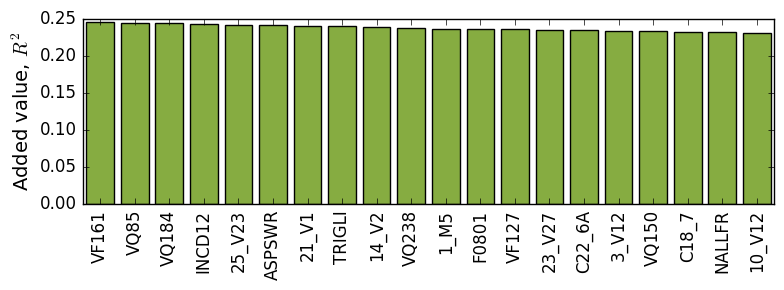

In [109]:
# Reading from file example
filename = 'inchianti_rfc'
feats, scores = takeOneFromFile(filename)
#baseline = 0.86 # Sard
baseline = 0.90 # InCH
scores = [baseline-x for x in scores]
N=20
pl.figure(figsize=(8,3))
#pl.xlabel('Top '+str(N) +' rank-ordered features')
pl.ylabel('Added value, $R^2$', fontsize=14)
#pl.bar(range(len(rank_order_feats[:N])), rank_order_scores[:N], color=[0.5,0,0], align='center')
pl.bar(range(len(feats[:N])), scores[:N], color='#86AC41', align='center')
pl.xticks(range(len(feats[:N])), feats[:N], size='small', rotation=90)
pl.xlim(min(range(len(feats[:N])))-0.5,max(range(len(feats[:N])))+0.5)
pl.tick_params(axis='both', which='major', labelsize=12)
pl.tick_params(axis='both', which='minor', labelsize=12)
pl.tight_layout()
pl.savefig('./Figures/TopFeats/'+filename+'_missingfeatures.png', dpi=800)
pl.show()

## Code for running Added Value and Pearson Correlation trait ranking methods

### Full-trait SardiNIA (ElNet)

initial feats:183
initial samps:6165


C:\Users\edsun\Anaconda3\lib\site-packages\ipykernel\__main__.py:75: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


cleaned features: 148
cleaned samples: 4817


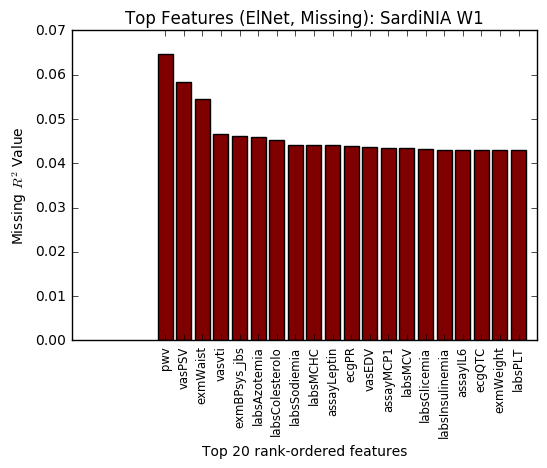

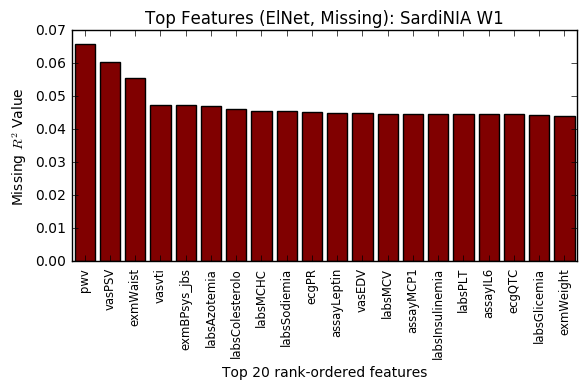

C:\Users\edsun\Anaconda3\lib\site-packages\scipy\stats\stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\Users\edsun\Anaconda3\lib\site-packages\scipy\stats\stats.py:5256: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


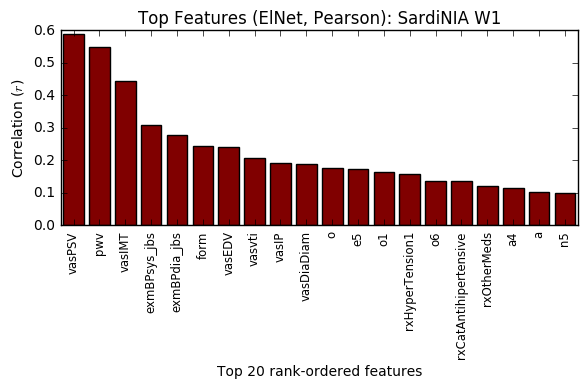

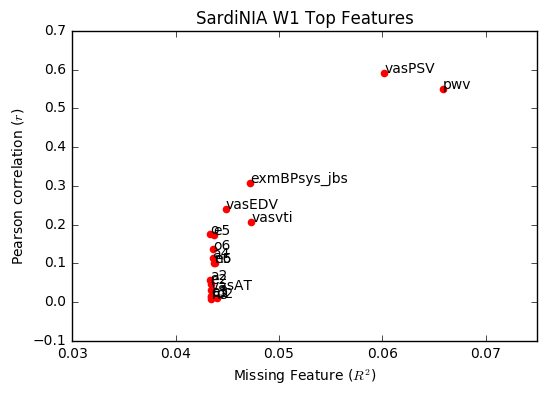

Reading common clinical features...
cleaned features: 65
cleaned samples: 5398


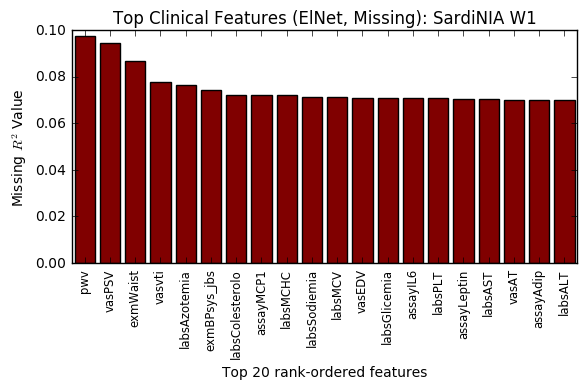

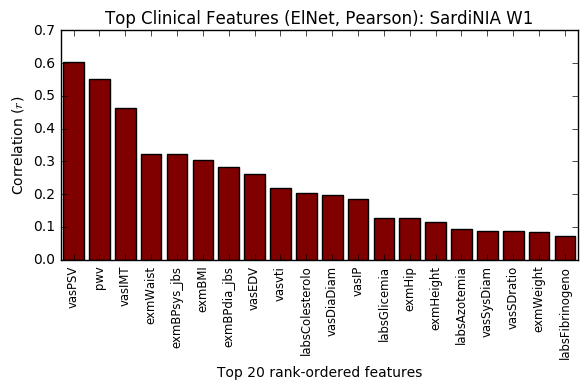

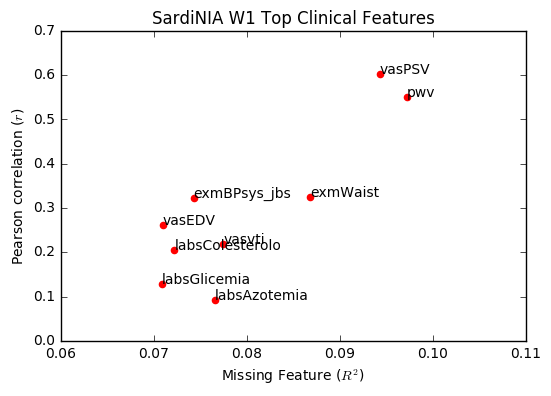

In [63]:
data_matrix, age_col_idx, id_col_idx, data_class_views, class_vals, col_names = Get_Binned_Data('sardinia_normal', '2013-12-18-Sardinia-CleanUp-Data-Wave1.tsv')
feats, scores = takeOneOutFeatureAnalysis_elnet(data_matrix, col_names, age_col_idx, id_col_idx, num_iters=100, 
                                          filename='sardinia_normal', N = 21, title='Top Features (ElNet, Missing): SardiNIA W1')
feats2, scores2 = PearsonFeatures('SardiNIA/wave1_normal_en','sardinia_normal', 'Top Features (ElNet, Pearson): SardiNIA W1', data_matrix, age_col_idx, id_col_idx, col_names, N=20)
plotTwoWays ('sardinia_normal', 'SardiNIA W1 Top Features', feats, scores, 'Missing Feature ($R^2$)', feats2, scores2, 'Pearson correlation ($r$)', N=60)

data_matrix, age_col_idx, id_col_idx, data_class_views, class_vals, col_names = Get_Binned_Data('sardinia_common_cardio', '2013-12-18-Sardinia-CleanUp-Data-Wave1.tsv')
feats, scores = takeOneOutFeatureAnalysis_elnet(data_matrix, col_names, age_col_idx, id_col_idx, num_iters=100, 
                                          filename='sardinia_common', N = 21, title='Top Clinical Features (ElNet, Missing): SardiNIA W1')
feats2, scores2 = PearsonFeatures('SardiNIA/wave1_common_en','sardinia_common_cardio', 'Top Clinical Features (ElNet, Pearson): SardiNIA W1', data_matrix, age_col_idx, id_col_idx, col_names, N=20)
plotTwoWays ('sardinia_common_cardio', 'SardiNIA W1 Top Clinical Features', feats, scores, 'Missing Feature ($R^2$)', feats2, scores2, 'Pearson correlation ($r$)', N=20)

### Full-trait SardiNIA (RFC)

initial feats:183
initial samps:6165
cleaned features: 148
cleaned samples: 4817


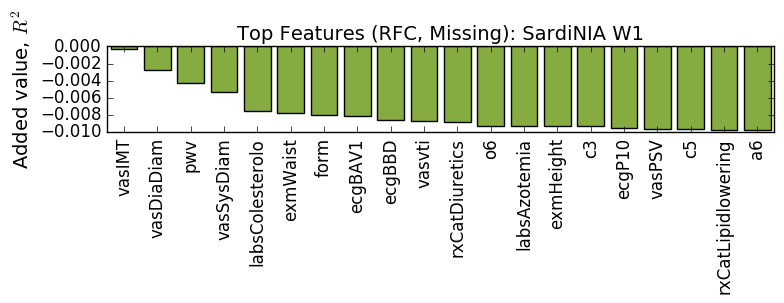

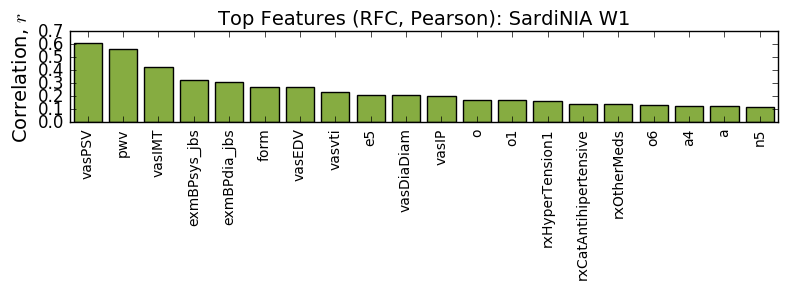

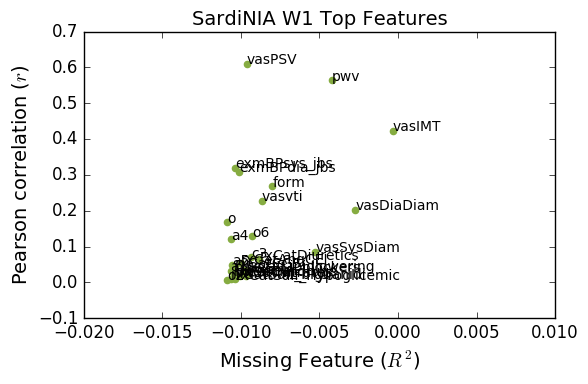

Reading common clinical features...
cleaned features: 65
cleaned samples: 5398


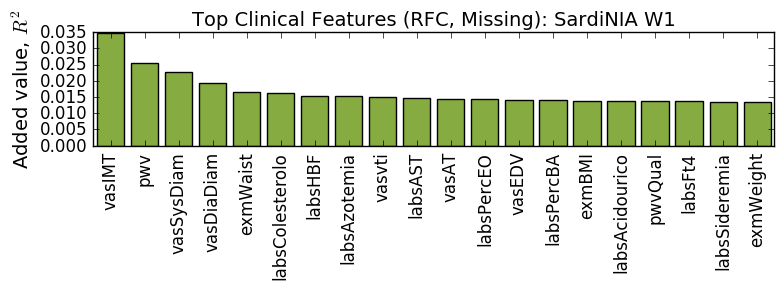

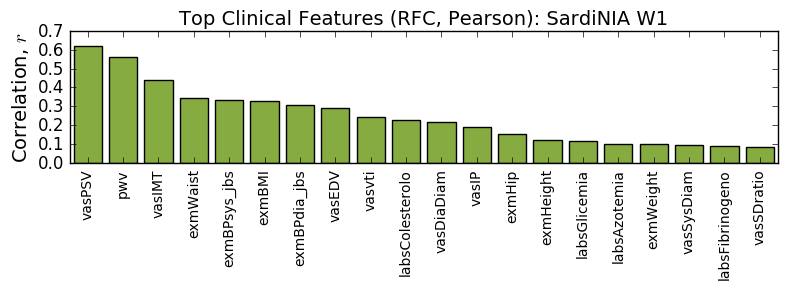

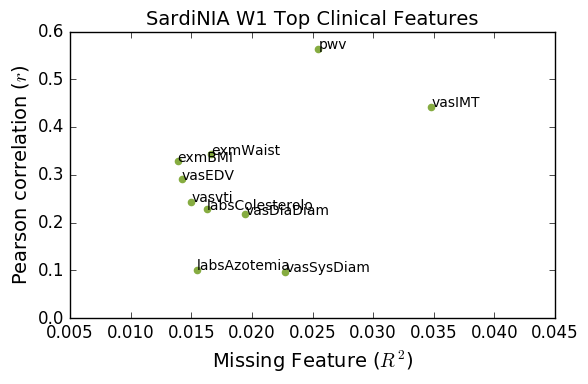

In [103]:
data_matrix, age_col_idx, id_col_idx, data_class_views, class_vals, col_names = Get_Binned_Data('sardinia_normal', '2013-12-18-Sardinia-CleanUp-Data-Wave1.tsv')
feats, scores = takeOneOutFeatureAnalysis_rfc(data_matrix, data_class_views, class_vals, col_names, age_col_idx, id_col_idx, num_iters=10, 
                                          filename='sardinia_normal_rfc', N = 21, title='Top Features (RFC, Missing): SardiNIA W1')
feats2, scores2 = PearsonFeatures('SardiNIA/wave1_normal_rf','sardinia_normal_rfc', 'Top Features (RFC, Pearson): SardiNIA W1', data_matrix, age_col_idx, id_col_idx, col_names, N=20)
plotTwoWays ('sardinia_normal_rfc', 'SardiNIA W1 Top Features', feats, scores, 'Missing Feature ($R^2$)', feats2, scores2, 'Pearson correlation ($r$)', N=60)

data_matrix, age_col_idx, id_col_idx, data_class_views, class_vals, col_names = Get_Binned_Data('sardinia_common_cardio', '2013-12-18-Sardinia-CleanUp-Data-Wave1.tsv')
feats, scores = takeOneOutFeatureAnalysis_rfc(data_matrix, data_class_views, class_vals, col_names, age_col_idx, id_col_idx, num_iters=10, 
                                          filename='sardinia_common_rfc', N = 21, title='Top Clinical Features (RFC, Missing): SardiNIA W1')
feats2, scores2 = PearsonFeatures('SardiNIA/wave1_common_rf','sardinia_common_cardio_rfc', 'Top Clinical Features (RFC, Pearson): SardiNIA W1', data_matrix, age_col_idx, id_col_idx, col_names, N=20)
plotTwoWays ('sardinia_common_cardio_rfc', 'SardiNIA W1 Top Clinical Features', feats, scores, 'Missing Feature ($R^2$)', feats2, scores2, 'Pearson correlation ($r$)', N=20)

# inCHIANTI

### ElNet

initial feats:2499
initial samps:1453


C:\Users\edsun\Anaconda3\lib\site-packages\ipykernel\__main__.py:75: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


cleaned features: 1602
cleaned samples: 702
using inchianti binning...


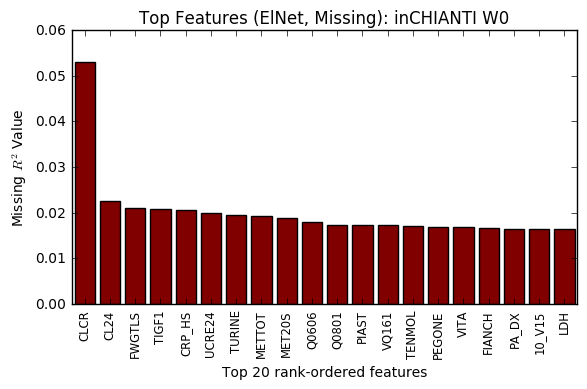

C:\Users\edsun\Anaconda3\lib\site-packages\scipy\stats\stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\Users\edsun\Anaconda3\lib\site-packages\scipy\stats\stats.py:5256: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


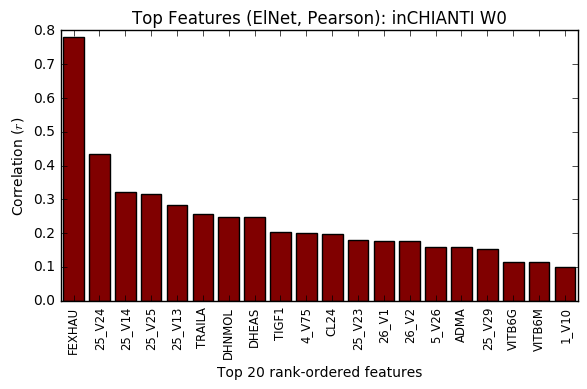

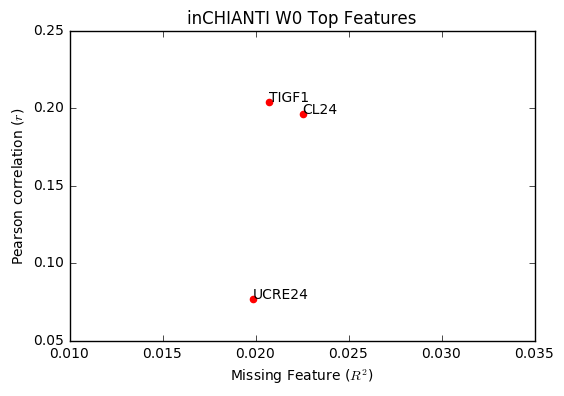

In [65]:
data_matrix, age_col_idx, id_col_idx, data_class_views, class_vals, col_names = Get_Binned_Data('inchianti', 'inChiantiAll-w0.tsv')
feats, scores = takeOneOutFeatureAnalysis_elnet(data_matrix, col_names, age_col_idx, id_col_idx, num_iters=100, 
                                          filename='inchianti', N = 21, title='Top Features (ElNet, Missing): inCHIANTI W0', baseline=0.87)
feats2, scores2 = PearsonFeatures('inCHIANTI/wave0_inchianti_en','inchianti', 'Top Features (ElNet, Pearson): inCHIANTI W0', data_matrix, age_col_idx, id_col_idx, col_names, N=20)
plotTwoWays ('inchianti', 'inCHIANTI W0 Top Features', feats, scores, 'Missing Feature ($R^2$)', feats2, scores2, 'Pearson correlation ($r$)', N=40)

### RFC

initial feats:2499
initial samps:1453
cleaned features: 1602
cleaned samples: 702
using inchianti binning...


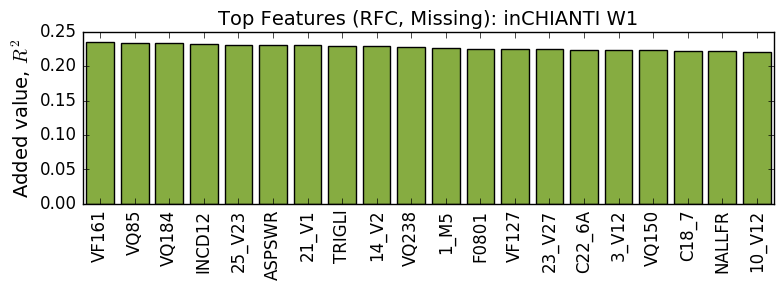

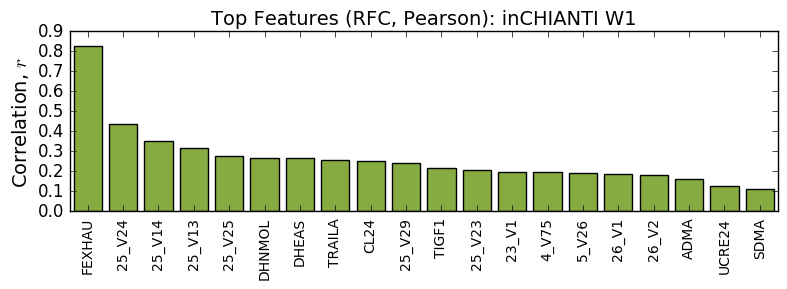

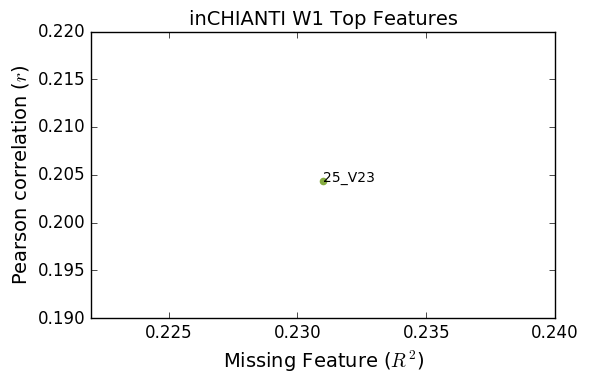

In [102]:
data_matrix, age_col_idx, id_col_idx, data_class_views, class_vals, col_names = Get_Binned_Data('inchianti', 'inChiantiAll-w0.tsv')
feats, scores = takeOneOutFeatureAnalysis_rfc(data_matrix, data_class_views, class_vals, col_names, age_col_idx, id_col_idx, num_iters=5, 
                                          filename='inchianti_rfc', N = 21, title='Top Features (RFC, Missing): inCHIANTI W1', baseline=0.89)
feats2, scores2 = PearsonFeatures('inCHIANTI/wave0_inchianti_rf','inchianti_rfc', 'Top Features (RFC, Pearson): inCHIANTI W1', data_matrix, age_col_idx, id_col_idx, col_names, N=20)
plotTwoWays ('inchianti_rfc', 'inCHIANTI W1 Top Features', feats, scores, 'Missing Feature ($R^2$)', feats2, scores2, 'Pearson correlation ($r$)', N=40)

## Code for Running Just Pearson Method (SardiNIA and InCHIANTI)

initial feats:183
initial samps:6165


C:\Users\edsun\Anaconda3\lib\site-packages\ipykernel\__main__.py:79: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


cleaned features: 148
cleaned samples: 4817


C:\Users\edsun\Anaconda3\lib\site-packages\scipy\stats\stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\Users\edsun\Anaconda3\lib\site-packages\scipy\stats\stats.py:5256: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


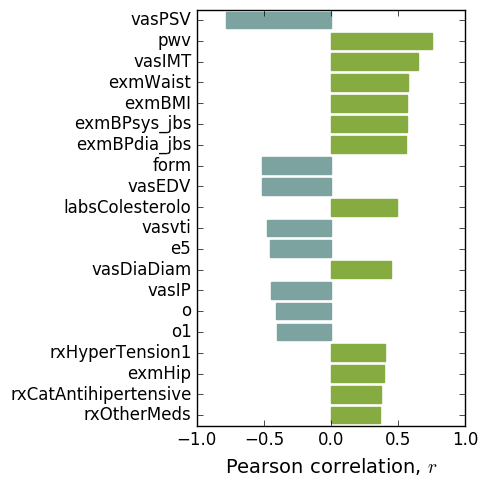

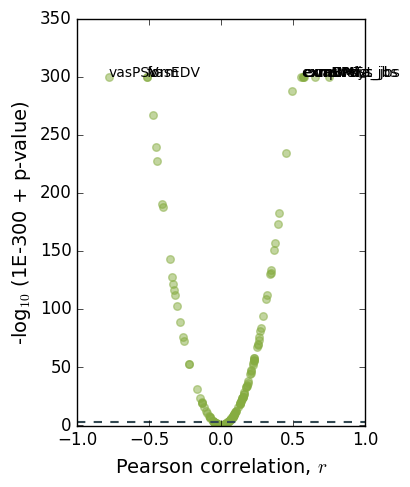

Reading common clinical features...
cleaned features: 65
cleaned samples: 5398


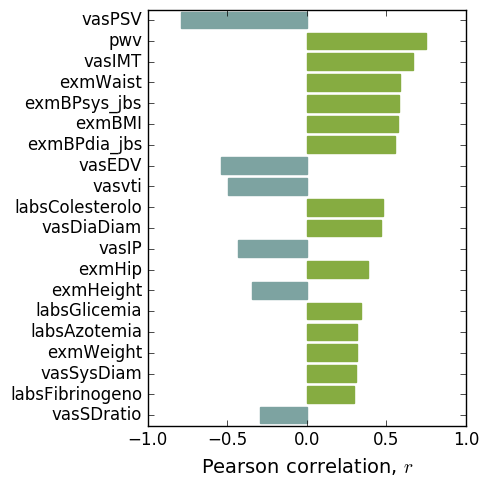

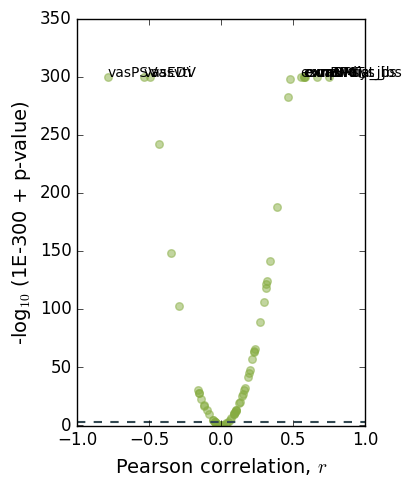

initial feats:2499
initial samps:1453
cleaned features: 1602
cleaned samples: 702
using inchianti binning...


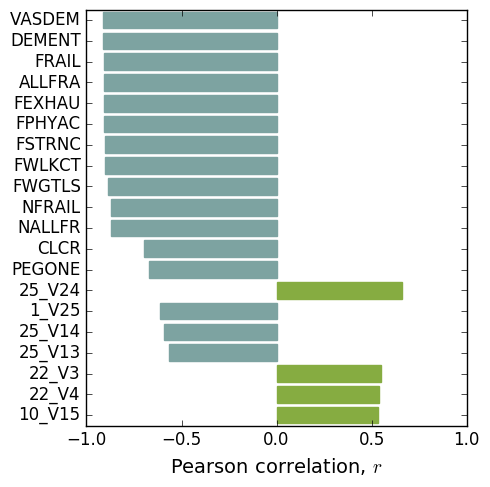

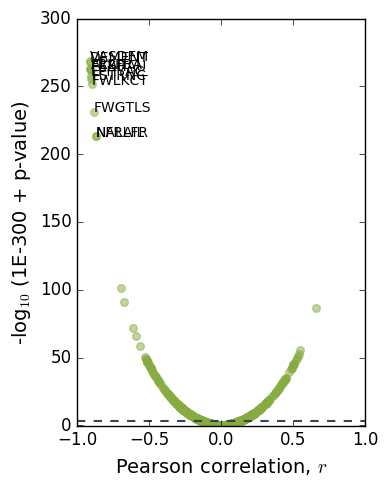

In [42]:
data_matrix, age_col_idx, id_col_idx, data_class_views, class_vals, col_names = Get_Binned_Data('sardinia_normal', '2013-12-18-Sardinia-CleanUp-Data-Wave1.tsv')
feats2, scores2 = PearsonFeatures('SardiNIA/wave1_normal_rf','sardinia_normal_rfc', 'Top Features (RFC, Pearson): SardiNIA W1', data_matrix, age_col_idx, id_col_idx, col_names, N=20,
                                  log_p_thresh=299, r_thresh=1.0)

data_matrix, age_col_idx, id_col_idx, data_class_views, class_vals, col_names = Get_Binned_Data('sardinia_common_cardio', '2013-12-18-Sardinia-CleanUp-Data-Wave1.tsv')
feats2, scores2 = PearsonFeatures('SardiNIA/wave1_common_rf','sardinia_common_cardio_rfc', 'Top Clinical Features (RFC, Pearson): SardiNIA W1', data_matrix, age_col_idx, id_col_idx, col_names, N=20,
                                 log_p_thresh=299, r_thresh=1.0)

data_matrix, age_col_idx, id_col_idx, data_class_views, class_vals, col_names = Get_Binned_Data('inchianti', 'inChiantiAll-w0.tsv')
feats2, scores2 = PearsonFeatures('inCHIANTI/wave0_inchianti_rf','inchianti_rfc', 'Top Features (RFC, Pearson): inCHIANTI W1', data_matrix, age_col_idx, id_col_idx, col_names, N=20,
                                 log_p_thresh=200, r_thresh=1.0)

#### Spearman Correlation

initial feats:183
initial samps:6165


C:\Users\edsun\Anaconda3\lib\site-packages\ipykernel\__main__.py:79: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


cleaned features: 148
cleaned samples: 4817


C:\Users\edsun\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\edsun\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\edsun\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\edsun\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\edsun\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


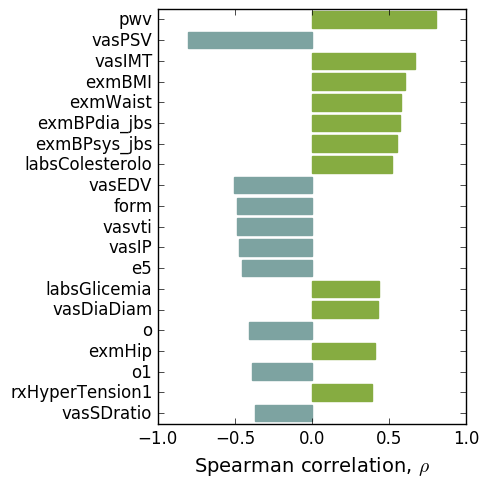

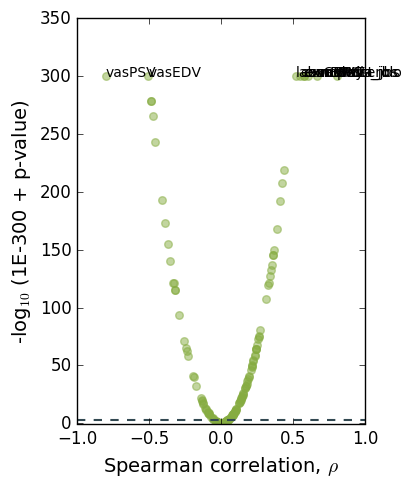

Reading common clinical features...
cleaned features: 65
cleaned samples: 5398


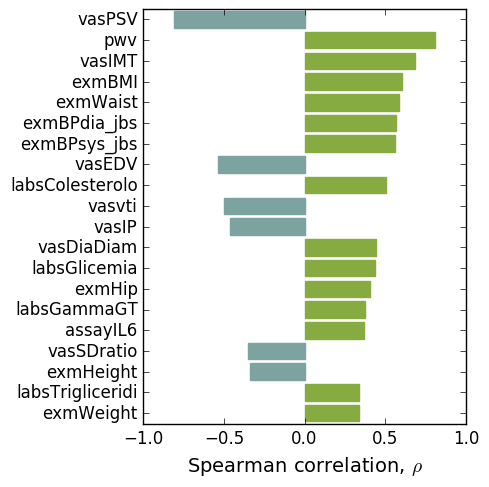

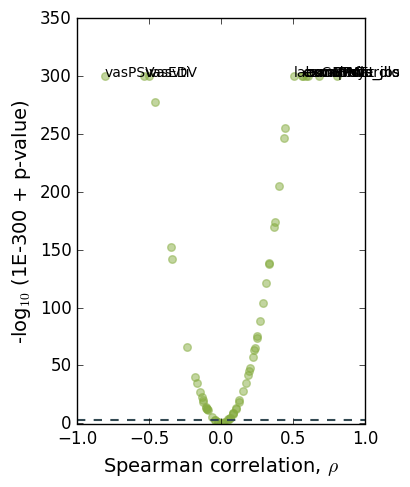

initial feats:2499
initial samps:1453
cleaned features: 1602
cleaned samples: 702
using inchianti binning...


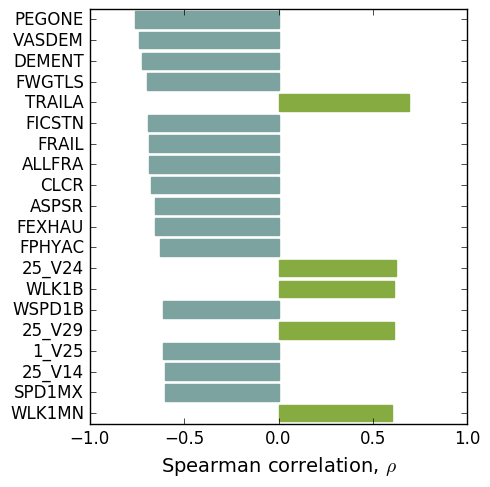

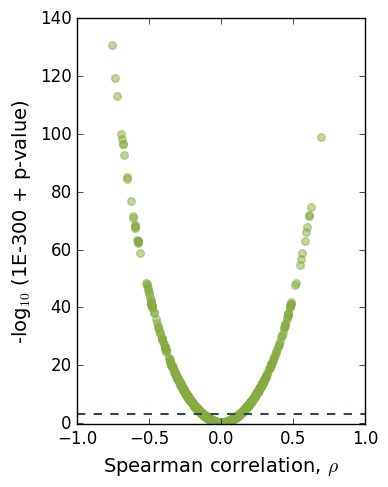

In [43]:
data_matrix, age_col_idx, id_col_idx, data_class_views, class_vals, col_names = Get_Binned_Data('sardinia_normal', '2013-12-18-Sardinia-CleanUp-Data-Wave1.tsv')
feats2, scores2 = PearsonFeatures('SardiNIA/wave1_normal_rf','sardinia_normal_rfc', 'Top Features (RFC, Pearson): SardiNIA W1', data_matrix, age_col_idx, id_col_idx, col_names, N=20,
                                  log_p_thresh=299, r_thresh=1.0, spearman=True)

data_matrix, age_col_idx, id_col_idx, data_class_views, class_vals, col_names = Get_Binned_Data('sardinia_common_cardio', '2013-12-18-Sardinia-CleanUp-Data-Wave1.tsv')
feats2, scores2 = PearsonFeatures('SardiNIA/wave1_common_rf','sardinia_common_cardio_rfc', 'Top Clinical Features (RFC, Pearson): SardiNIA W1', data_matrix, age_col_idx, id_col_idx, col_names, N=20,
                                 log_p_thresh=299, r_thresh=1.0, spearman=True)

data_matrix, age_col_idx, id_col_idx, data_class_views, class_vals, col_names = Get_Binned_Data('inchianti', 'inChiantiAll-w0.tsv')
feats2, scores2 = PearsonFeatures('inCHIANTI/wave0_inchianti_rf','inchianti_rfc', 'Top Features (RFC, Pearson): inCHIANTI W1', data_matrix, age_col_idx, id_col_idx, col_names, N=20,
                                 log_p_thresh=200, r_thresh=1.0, spearman=True)

## Significant (t-test) trait differences between top/bottom PAR quartiles

### Full-trait, RFC

In [53]:
data_matrix, age_col_idx, id_col_idx, data_class_views, class_vals, col_names = Get_Binned_Data('sardinia_normal', '2013-12-18-Sardinia-CleanUp-Data-Wave1.tsv')
feats, p_vals, fcs, x, clean, col = ttest_features ('SardiNIA/wave1_normal_rf', data_matrix, col_names, age_col_idx, id_col_idx)

initial feats:183
initial samps:6165


C:\Users\edsun\Anaconda3\lib\site-packages\ipykernel\__main__.py:79: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


cleaned features: 148
cleaned samples: 4817


C:\Users\edsun\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\edsun\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\edsun\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
C:\Users\edsun\Anaconda3\lib\site-packages\ipykernel\__main__.py:107: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\edsun\Anaconda3\lib\site-packages\ipykernel\__main__.py:107: RuntimeWarning: divide by zero encountered in double_scalars


C:\Users\edsun\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: divide by zero encountered in log2
  from ipykernel import kernelapp as app


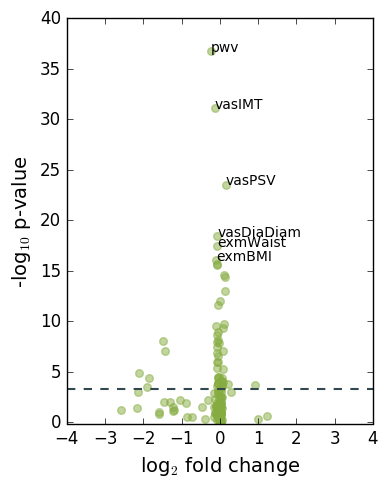

In [54]:
log_pvals = -np.log10(np.array(p_vals))
log_fcs = np.log2(np.array(fcs))

pl.figure(figsize=(4,5))
pl.ylabel('-log$_{10}$ p-value', fontsize=14)
pl.xlabel('log$_2$ fold change', fontsize=14)
pl.scatter(log_fcs, log_pvals, color='#86AC41', alpha=0.5, s=30)
pl.xlim(-4,4)
pl.ylim(-0.1,None)
#pl.xlim(-2, 10)
#pl.xlim(-0.75, 0.75)
#x_range = np.linspace(-2, 10,10)
x_range = np.linspace(-4,4,10)
pl.plot(x_range, -np.log10(5*10**(-4)) * np.ones(len(x_range)), color='#324851', linestyle='--', linewidth=1.5)
for i, txt in enumerate(feats):
    if log_pvals[i] > 16:#57.5:
        pl.annotate(txt, (log_fcs[i],log_pvals[i]))
    elif np.abs(log_fcs[i]) > 0.5 and log_pvals[i] > -np.log10(0.05*10**(-10)):
        if txt=='rxCatAntihipertensive':
            pl.annotate(txt, (log_fcs[i]-0.2,log_pvals[i]-4))
        else:
            pl.annotate(txt, (log_fcs[i],log_pvals[i]))
pl.tick_params(axis='both', which='major', labelsize=12)
pl.tick_params(axis='both', which='minor', labelsize=12)
pl.tight_layout()
pl.savefig('./Figures/TopFeats/volcano_normal_rf.png', dpi=800)
pl.show()

### Full-trait, ElNet

In [55]:
data_matrix, age_col_idx, id_col_idx, data_class_views, class_vals, col_names = Get_Binned_Data('sardinia_normal', '2013-12-18-Sardinia-CleanUp-Data-Wave1.tsv')
feats, p_vals, fcs, x, clean, col = ttest_features ('SardiNIA/wave1_normal_en', data_matrix, col_names, age_col_idx, id_col_idx)

initial feats:183
initial samps:6165


C:\Users\edsun\Anaconda3\lib\site-packages\ipykernel\__main__.py:79: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


cleaned features: 148
cleaned samples: 4817


C:\Users\edsun\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\edsun\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\edsun\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
C:\Users\edsun\Anaconda3\lib\site-packages\ipykernel\__main__.py:107: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\edsun\Anaconda3\lib\site-packages\ipykernel\__main__.py:107: RuntimeWarning: divide by zero encountered in double_scalars


C:\Users\edsun\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: divide by zero encountered in log2
  from ipykernel import kernelapp as app


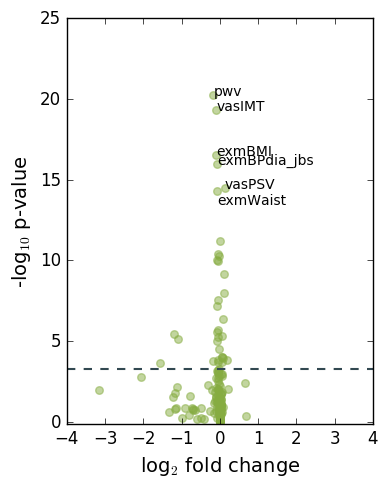

In [56]:
log_pvals = -np.log10(np.array(p_vals))
log_fcs = np.log2(np.array(fcs))

pl.figure(figsize=(4,5))
pl.ylabel('-log$_{10}$ p-value', fontsize=14)
pl.xlabel('log$_2$ fold change', fontsize=14)
pl.scatter(log_fcs, log_pvals, color='#86AC41', alpha=0.5, s=30)
pl.xlim(-4,4)
pl.ylim(-0.1,None)
#pl.xlim(-2, 10)
#pl.xlim(-0.75, 0.75)
x_range = np.linspace(-4,4,10)
pl.plot(x_range, -np.log10(5*10**(-4)) * np.ones(len(x_range)), color='#324851', linestyle='--', linewidth=1.5)
for i, txt in enumerate(feats):
    if log_pvals[i] > 12:#50:
    #elif np.abs(log_fcs[i]) > 0.5 and log_pvals[i] > -np.log10(0.05*10**(-10)):
        if txt=='exmWaist':
            pl.annotate(txt, (log_fcs[i],log_pvals[i]-0.8))
        else:
            pl.annotate(txt, (log_fcs[i],log_pvals[i]))
pl.tick_params(axis='both', which='major', labelsize=12)
pl.tick_params(axis='both', which='minor', labelsize=12)
pl.tight_layout()
pl.savefig('./Figures/TopFeats/volcano_normal_en.png', dpi=800)
pl.show()

### 65-trait, RFC

In [57]:
data_matrix, age_col_idx, id_col_idx, data_class_views, class_vals, col_names = Get_Binned_Data('sardinia_common_cardio', '2013-12-18-Sardinia-CleanUp-Data-Wave1.tsv')
feats, p_vals, fcs, x, clean, col = ttest_features ('SardiNIA/wave1_common_rf', data_matrix, col_names, age_col_idx, id_col_idx)

Reading common clinical features...


C:\Users\edsun\Anaconda3\lib\site-packages\ipykernel\__main__.py:79: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


cleaned features: 65
cleaned samples: 5398


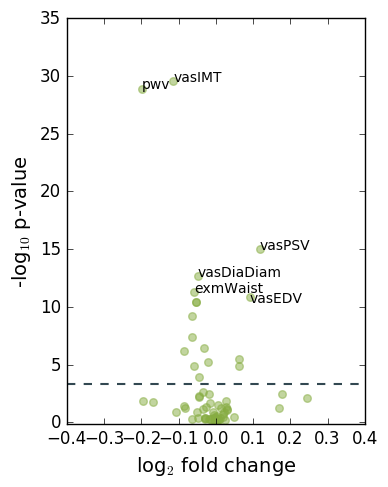

In [58]:
log_pvals = -np.log10(np.array(p_vals))
log_fcs = np.log2(np.array(fcs))

pl.figure(figsize=(4,5))
pl.ylabel('-log$_{10}$ p-value', fontsize=14)
pl.xlabel('log$_2$ fold change', fontsize=14)
pl.scatter(log_fcs, log_pvals, color='#86AC41', alpha=0.5, s=30)
pl.xlim(-0.4, 0.4)
pl.ylim(-0.1,None)
x_range = np.linspace(-0.4, 0.4,10)
pl.plot(x_range, -np.log10(5*10**(-4)) * np.ones(len(x_range)), color='#324851', linestyle='--', linewidth=1.5)
for i, txt in enumerate(feats):
    if log_pvals[i] > 10.5:
        if txt == 'vasEDV':
            pl.annotate(txt, (log_fcs[i],log_pvals[i]-0.5))
        else:
            pl.annotate(txt, (log_fcs[i],log_pvals[i]))
    #elif np.abs(log_fcs[i]) > 0.5 and log_pvals[i] > -np.log10(0.05*10**(-10)):
        #pl.annotate(txt, (log_fcs[i],log_pvals[i]))
        #continue
pl.tick_params(axis='both', which='major', labelsize=12)
pl.tick_params(axis='both', which='minor', labelsize=12)
pl.tight_layout()
pl.savefig('./Figures/TopFeats/volcano_common_rf.png', dpi=800)
pl.show()

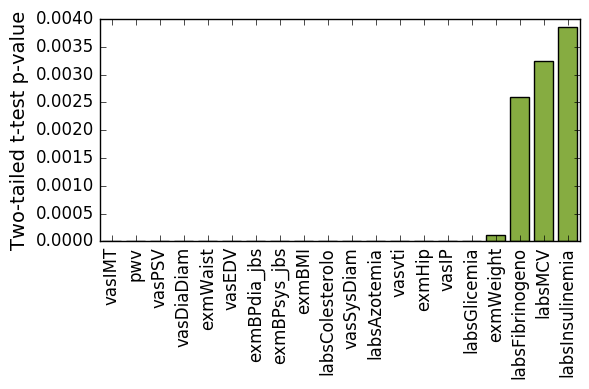

In [71]:
N=20

pl.figure()
pl.ylabel('Two-tailed t-test p-value', fontsize=14)
pl.bar(range(len(feats[:N])), p_vals[:N], color='#86AC41', align='center')
pl.xticks(range(len(feats[:N])), feats[:N], size='small', rotation=90)
pl.xlim(min(range(len(feats[:N])))-0.5,max(range(len(feats[:N])))+0.5)
pl.tick_params(axis='both', which='major', labelsize=12)
pl.tick_params(axis='both', which='minor', labelsize=12)
pl.tight_layout()
pl.savefig('./Figures/TopFeats/bound_SardW1_ttest_rf_commoncard.png', dpi=800)
pl.show()

### 65-trait, ElNet

In [59]:
data_matrix, age_col_idx, id_col_idx, data_class_views, class_vals, col_names = Get_Binned_Data('sardinia_common_cardio', '2013-12-18-Sardinia-CleanUp-Data-Wave1.tsv')
feats, p_vals, fcs, x, clean, col = ttest_features ('SardiNIA/wave1_common_en', data_matrix, col_names, age_col_idx, id_col_idx)

Reading common clinical features...


C:\Users\edsun\Anaconda3\lib\site-packages\ipykernel\__main__.py:79: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


cleaned features: 65
cleaned samples: 5398


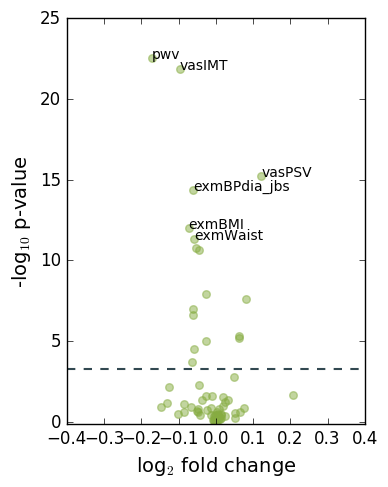

In [60]:
log_pvals = -np.log10(np.array(p_vals))
log_fcs = np.log2(np.array(fcs))

pl.figure(figsize=(4,5))
pl.ylabel('-log$_{10}$ p-value', fontsize=14)
pl.xlabel('log$_2$ fold change', fontsize=14)
pl.scatter(log_fcs, log_pvals, color='#86AC41', alpha=0.5, s=30)
pl.xlim(-0.4,0.4)
pl.ylim(-0.1,None)
x_range = np.linspace(-0.4,0.4,10)
pl.plot(x_range, -np.log10(5*10**(-4)) * np.ones(len(x_range)), color='#324851', linestyle='--', linewidth=1.5)
for i, txt in enumerate(feats):
    if log_pvals[i] > 11:
        pl.annotate(txt, (log_fcs[i],log_pvals[i]))
    elif np.abs(log_fcs[i]) > 0.5 and log_pvals[i] > -np.log10(0.05*10**(-10)):
        pl.annotate(txt, (log_fcs[i],log_pvals[i]))
pl.tick_params(axis='both', which='major', labelsize=12)
pl.tick_params(axis='both', which='minor', labelsize=12)
pl.tight_layout()
pl.savefig('./Figures/TopFeats/volcano_common_en.png', dpi=800)
pl.show()

### inCHIANTI

In [61]:
data_matrix, age_col_idx, id_col_idx, data_class_views, class_vals, col_names = Get_Binned_Data('inchianti', 'inChiantiAll-w0.tsv')
feats, p_vals, fcs, x, clean, col = ttest_features ('inCHIANTI/wave0_inchianti_rf', data_matrix, col_names, age_col_idx, id_col_idx)

initial feats:2499
initial samps:1453


C:\Users\edsun\Anaconda3\lib\site-packages\ipykernel\__main__.py:79: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


cleaned features: 1602
cleaned samples: 702
using inchianti binning...


C:\Users\edsun\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\edsun\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\edsun\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
C:\Users\edsun\Anaconda3\lib\site-packages\ipykernel\__main__.py:107: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\edsun\Anaconda3\lib\site-packages\ipykernel\__main__.py:107: RuntimeWarning: divide by zero encountered in double_scalars


C:\Users\edsun\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: divide by zero encountered in log2
  from ipykernel import kernelapp as app


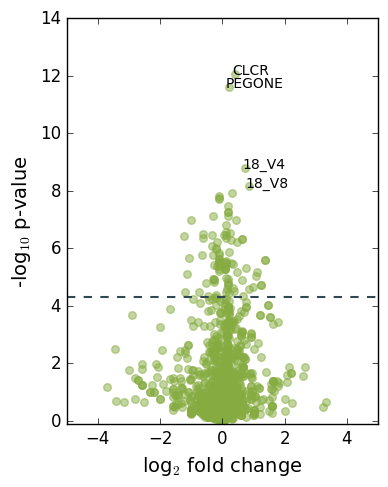

In [62]:
log_pvals = -np.log10(np.array(p_vals))
log_fcs = np.log2(np.array(fcs))

pl.figure(figsize=(4,5))
pl.ylabel('-log$_{10}$ p-value', fontsize=14)
pl.xlabel('log$_2$ fold change', fontsize=14)
pl.scatter(log_fcs, log_pvals, color='#86AC41', alpha=0.5, s=30)
pl.xlim(-5,5)
pl.ylim(-0.1,None)
x_range = np.linspace(-5, 5,10)
pl.plot(x_range, -np.log10(5*10**(-5)) * np.ones(len(x_range)), color='#324851', linestyle='--', linewidth=1.5)
for i, txt in enumerate(feats):
    if log_pvals[i] > 8:
        pl.annotate(txt, (log_fcs[i]-0.1,log_pvals[i]))
    #elif np.abs(log_fcs[i]) > 0.5 and log_pvals[i] > -np.log10(0.05*10**(-10)):
    #    pl.annotate(txt, (log_fcs[i],log_pvals[i]))
pl.tick_params(axis='both', which='major', labelsize=12)
pl.tick_params(axis='both', which='minor', labelsize=12)
pl.tight_layout()
pl.savefig('./Figures/TopFeats/volcano_inCH_en.png', dpi=800)
pl.show()

## Save trait rankings and scores as combined results file

In [46]:
saveTopTraits (filename='sardinia_normal', data_file='2013-12-18-Sardinia-CleanUp-Data-Wave1.tsv', rates_file='SardiNIA/wave1_normal_rf')
saveTopTraits (filename='sardinia_common', data_file='2013-12-18-Sardinia-CleanUp-Data-Wave1.tsv', rates_file='SardiNIA/wave1_common_rf')
saveTopTraits (filename='inchianti', data_file='inChiantiAll-w0.tsv', rates_file='inCHIANTI/wave0_inchianti_rf')

initial feats:183
initial samps:6165


C:\Users\edsun\Anaconda3\lib\site-packages\ipykernel\__main__.py:79: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


cleaned features: 148
cleaned samples: 4817


C:\Users\edsun\Anaconda3\lib\site-packages\scipy\stats\stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\Users\edsun\Anaconda3\lib\site-packages\scipy\stats\stats.py:5256: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0
C:\Users\edsun\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\edsun\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\edsun\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
C:\Users\edsun\Anaconda3\lib\site-packages\ipykernel\__main__.py:107: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\edsun\Anac

Reading common clinical features...
cleaned features: 65
cleaned samples: 5398
initial feats:2499
initial samps:1453
cleaned features: 1602
cleaned samples: 702
using inchianti binning...
-0.901130739758819


## Miscellaneous: Visualizing top feature values with chronological age and PAR

initial feats:183
initial samps:6165


C:\Users\edsun\Anaconda3\lib\site-packages\ipykernel\__main__.py:75: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


cleaned features: 148
cleaned samples: 4817


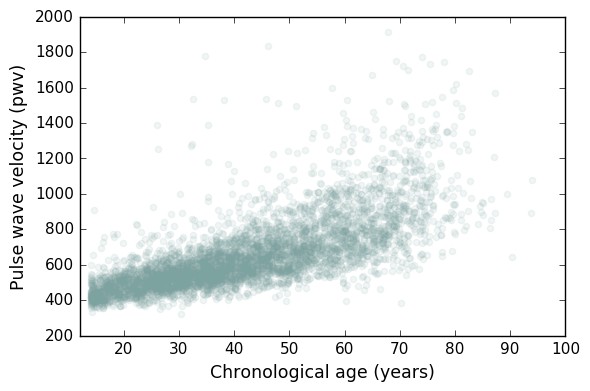

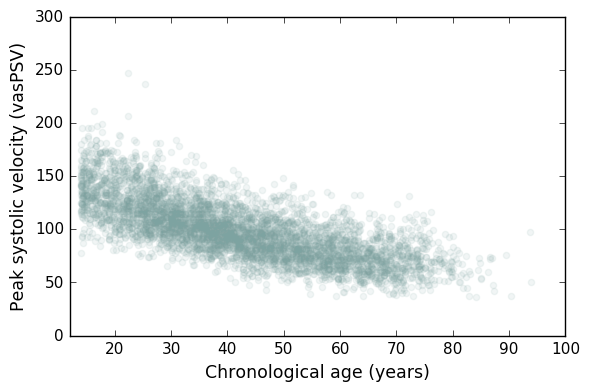

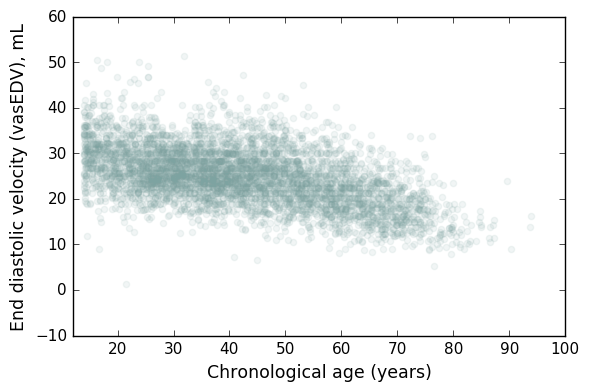

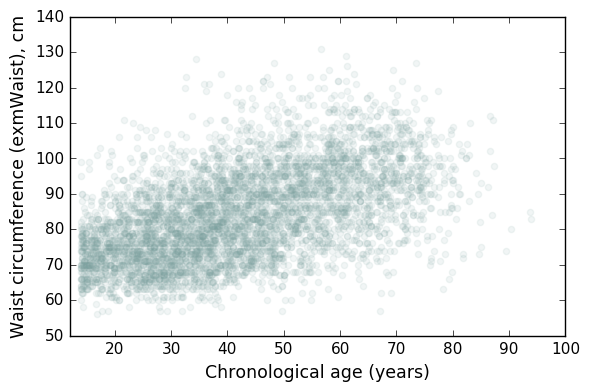

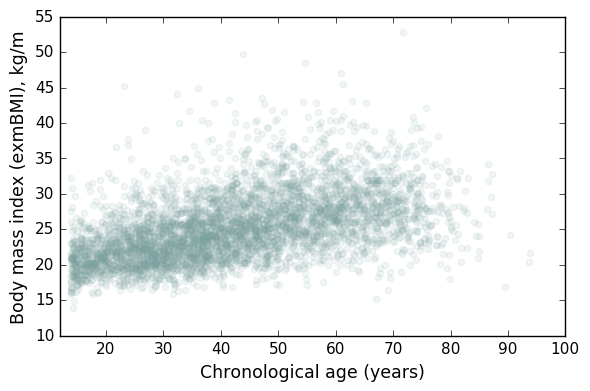

In [104]:
top_features = ['pwv', 'vasPSV', 'vasEDV', 'exmWaist', 'exmBMI']
feat_names = ['Pulse wave velocity (pwv)', 'Peak systolic velocity (vasPSV)', 'End diastolic velocity (vasEDV), mL', 'Waist circumference (exmWaist), cm', 'Body mass index (exmBMI), kg/m']
data_matrix, age_col_idx, id_col_idx, data_class_views, class_vals, col_names = Get_Binned_Data('sardinia_normal', '2013-12-18-Sardinia-CleanUp-Data-Wave1.tsv')

for i, top_feat in enumerate(top_features):
    chron_ages = data_matrix[:,age_col_idx]
    feat_col_idx = np.where(col_names==top_feat)
    feat_vals = data_matrix[:,feat_col_idx]
    pl.figure()
    pl.xlim(12,100)
    pl.scatter(chron_ages, feat_vals, color='#7DA3A1', alpha=0.1)
    pl.xlabel('Chronological age (years)', fontsize=12.5)
    pl.ylabel(feat_names[i], fontsize=12.5)
    pl.tick_params(axis='both', which='major', labelsize=11)
    pl.tick_params(axis='both', which='minor', labelsize=11)
    pl.tight_layout()
    pl.savefig('./Figures/TopFeats/'+str(top_feat)+'_age.png', dpi=800)
    pl.show()

In [ ]:
top_features = ['pwv', 'vasPSV', 'vasEDV', 'exmWaist', 'exmBMI']
feat_names = ['Pulse wave velocity (pwv)', 'Peak systolic velocity (vasPSV)', 'End diastolic velocity (vasEDV), mL', 'Waist circumference (exmWaist), cm', 'Body mass index (exmBMI), kg/m']
data_matrix, age_col_idx, id_col_idx, data_class_views, class_vals, col_names = Get_Binned_Data('sardinia_normal', '2013-12-18-Sardinia-CleanUp-Data-Wave1.tsv')
feats, p_vals, fcs, x, data_matrix, col_names = ttest_features ('SardiNIA/wave1_normal_rf', data_matrix, col_names, age_col_idx, id_col_idx, rescale='linear')

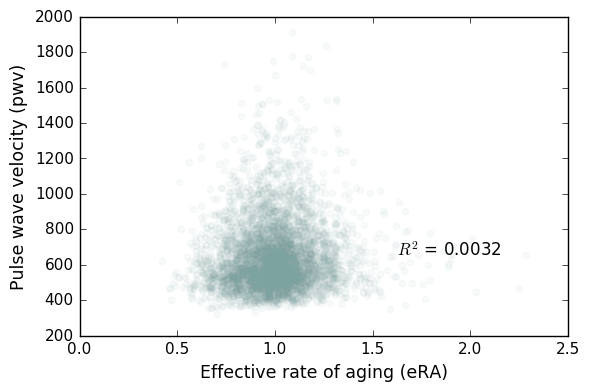

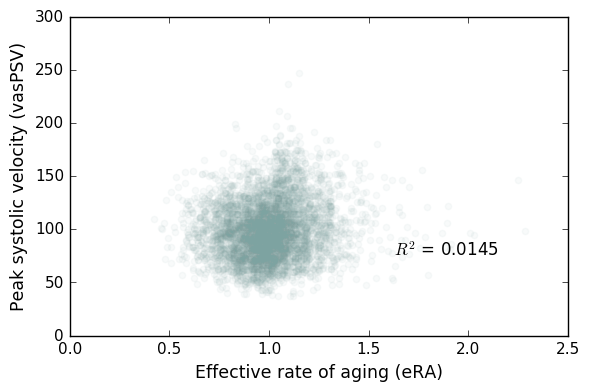

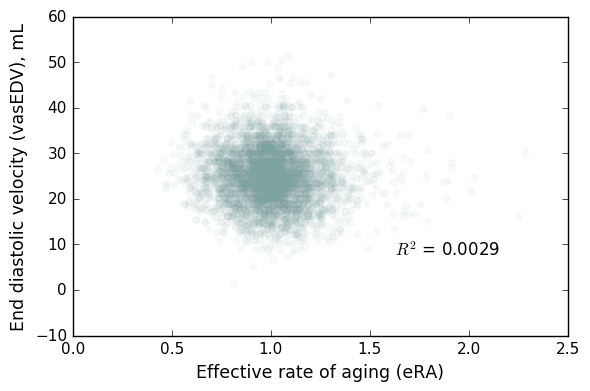

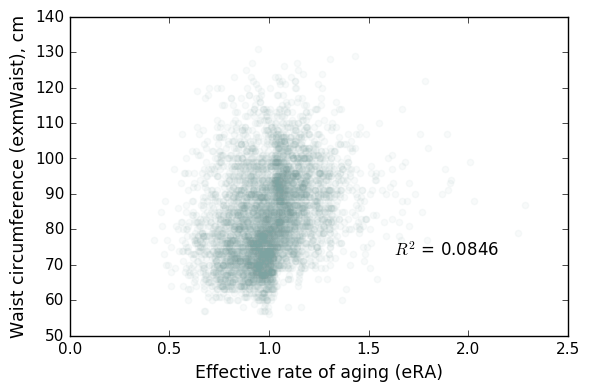

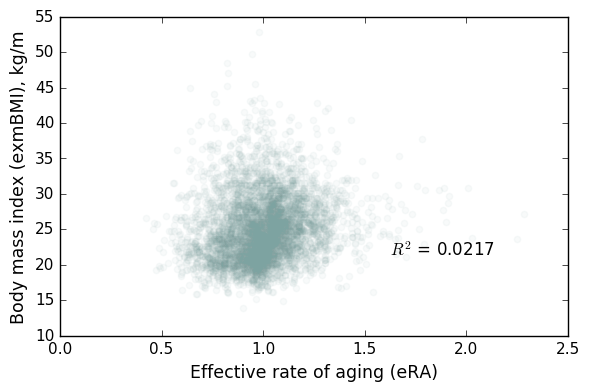

In [23]:
for i, top_feat in enumerate(top_features):
    feat_col_idx = np.where(col_names==top_feat)
    feat_vals = data_matrix[:,feat_col_idx]
    id_col = data_matrix[:,0]
    idxs = np.argsort(id_col)
    feat_vals = feat_vals[idxs]
    pl.figure()
    pl.scatter(x, feat_vals, color='#7DA3A1', alpha=0.05)
    pl.xlabel('Physiological aging rate (PAR)', fontsize=12.5)
    pl.ylabel(feat_names[i], fontsize=12.5)
    pl.tick_params(axis='both', which='major', labelsize=11)
    pl.tick_params(axis='both', which='minor', labelsize=11)
    pearson, p = pearsonr(x, feat_vals[:,0,0])
    pl.annotate('$R^2$ = '+str("%.3f" %(pearson*pearson)), xy=(0.65, 0.25), xycoords='axes fraction', fontsize=12)
    pl.tight_layout()
    pl.savefig('./Figures/TopFeats/'+str(top_feat)+'_eRA.png', dpi=800)
    pl.show()